<a href="https://colab.research.google.com/github/Manith-Ratnayake/Data-Enginnering/blob/main/Data_Engineering2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Data Pre Proccessing**

In [225]:
# Google drive and google collab connection
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [226]:
# In google collab pyspark is not pre installed
!pip install pyspark

### **Preparing Data**

In [227]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [228]:
# Pysaprk Library
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, median, stddev

In [229]:
# Creating a py spark session
spark = SparkSession.builder.appName("sparkApp").getOrCreate()

In [230]:
# Reading three files
col_mat_nuw_data = spark.read.csv("/content/drive/My Drive/Data Engineering/col_mat_nuw_output.csv", header=False, inferSchema = True)
kan_data         = spark.read.csv("/content/drive/My Drive/Data Engineering/kan_output.csv", header=False, inferSchema = True )
mon_kur_jaf_data = spark.read.csv("/content/drive/My Drive/Data Engineering/mon_kur_jaf_output.csv", header=False, inferSchema = True)

# Combining all files into 1 file
df_spark = col_mat_nuw_data.union(mon_kur_jaf_data).union(kan_data)

# Checking the current column names
print(df_spark.columns)

# Rename the columns to more meaningful names
df_spark = df_spark.withColumnRenamed('_c0', 'HCHO Reading') \
                   .withColumnRenamed('_c1', 'Location') \
                   .withColumnRenamed('_c2', 'Current Date') \
                   .withColumnRenamed('_c3', 'Next Date')

print(df_spark.columns)

['_c0', '_c1', '_c2', '_c3']
['HCHO Reading', 'Location', 'Current Date', 'Next Date']


In [231]:
from pyspark.sql.functions import to_date

# Convert 'Current Date' and 'Next Date' columns from object to date data type
df_spark = df_spark.withColumn('Current Date', to_date(df_spark['Current Date'], 'yyyy/MM/dd'))
df_spark = df_spark.withColumn('Next Date', to_date(df_spark['Next Date'], 'yyyy/MM/dd'))

In [232]:
# Data types in the column
for col_name, data_type in df_spark.dtypes:
    print(f"Column '{col_name}' has data type: {data_type}")

Column 'HCHO Reading' has data type: double
Column 'Location' has data type: string
Column 'Current Date' has data type: date
Column 'Next Date' has data type: date


In [233]:
df_spark.printSchema()

root
 |-- HCHO Reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)



In [234]:
df_spark.show()

+--------------------+--------------+------------+----------+
|        HCHO Reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

###**Missing Values**

In [235]:
from pyspark.sql.functions import col, sum as pyspark_sum

# Define a list of column names
columns = df_spark.columns

# Create a dictionary to store the count of missing values for each column
missing_value_counts = {}

# Loop through each column and count the missing values
for col_name in columns:
    missing_count = df_spark.filter(col(col_name).isNull()).count()
    missing_value_counts[col_name] = missing_count

# Print the count of missing values for each column
print("Number of missing values in each column:\n")
for col_name, count in missing_value_counts.items():
    print(col_name, ": ", count)

Number of missing values in each column:

HCHO Reading :  4864
Location :  0
Current Date :  0
Next Date :  0


###**Filling the missing values**

In [236]:
from pyspark.sql.functions import mean as pyspark_mean, when

# Impute missing values for numerical columns with the mean
numerical_columns = ['HCHO Reading']  # Assuming 'HCHO Reading' is the only numerical column
for col_name in numerical_columns:
    mean_value = df_spark.select(pyspark_mean(col(col_name)).alias('mean')).collect()[0]['mean']
    df_spark = df_spark.withColumn(col_name, when(col(col_name).isNull(), mean_value).otherwise(col(col_name)))

# Impute missing values for categorical columns with the most frequent category
categorical_columns = ['Location', 'Current Date', 'Next Date']  # Assuming these are categorical columns
for col_name in categorical_columns:
    most_frequent_value = df_spark.groupBy(col_name).count().orderBy(col('count').desc()).first()[col_name]
    df_spark = df_spark.withColumn(col_name, when(col(col_name).isNull(), most_frequent_value).otherwise(col(col_name)))

# Recheck missing values after imputation
missing_value_counts_after_imputation = {}
for col_name in df_spark.columns:
    missing_count = df_spark.filter(col(col_name).isNull()).count()
    missing_value_counts_after_imputation[col_name] = missing_count

# Print the count of missing values for each column after imputation
print("Number of missing values in each column after imputation:")
for col_name, count in missing_value_counts_after_imputation.items():
    print(col_name, ": ", count)

Number of missing values in each column after imputation:
HCHO Reading :  0
Location :  0
Current Date :  0
Next Date :  0


In [237]:
df_spark.describe()

DataFrame[summary: string, HCHO Reading: string, Location: string]

In [238]:
df_pandas = df_spark.toPandas()
df_pandas.describe()

HCHO Reading
count  12782.000000
mean       0.000119
std        0.000073
min       -0.000352
25%        0.000093
50%        0.000119
75%        0.000132
max        0.000900

###**Statistics of Data**

In [239]:
from pyspark.sql.functions import abs, stddev, mean, col

# Calculate mean and standard deviation for each location
location_stats = df_spark.groupBy('Location').agg(mean('HCHO Reading').alias('mean'), stddev('HCHO Reading').alias('stddev'))

# Join the mean and standard deviation back to the original DataFrame
df_with_stats = df_spark.join(location_stats, on='Location', how='left')

# Define z-score threshold
z_score_threshold = 3

# Calculate z-score for each data point within its location group
df_filtered = df_with_stats.withColumn('z_score', abs(col('HCHO Reading') - col('mean')) / col('stddev')) \
                           .filter(col('z_score') <= z_score_threshold)


In [240]:
from pyspark.sql.functions import mean, median, stddev

# Calculate descriptive statistics for each city
city_statistics = df_spark.groupBy('Location') \
    .agg(mean('HCHO Reading').alias('Mean HCHO Reading'),
         median('HCHO Reading').alias('Median HCHO Reading'),
         stddev('HCHO Reading').alias('Stddev HCHO Reading'))

# Calculate descriptive statistics across the entire dataset
overall_statistics = df_spark.agg(mean('HCHO Reading').alias('Overall Mean HCHO Reading'),
                                  median('HCHO Reading').alias('Overall Median HCHO Reading'),
                                  stddev('HCHO Reading').alias('Overall Stddev HCHO Reading'))

# Show descriptive statistics for each city
print("Descriptive statistics for each city:")
city_statistics.show()

# Show descriptive statistics across the entire dataset
print("Descriptive statistics across the entire dataset:")
overall_statistics.show()

Descriptive statistics for each city:
+-------------------+--------------------+--------------------+--------------------+
|           Location|   Mean HCHO Reading| Median HCHO Reading| Stddev HCHO Reading|
+-------------------+--------------------+--------------------+--------------------+
|   Deniyaya, Matara|1.044686072749091...|1.192778916513748...|7.246053723404124E-5|
|     Colombo Proper|1.480916996036323...|1.192778916513748...| 8.67733015675361E-5|
|Nuwara Eliya Proper|1.065550795445532...|1.192778916513748...|5.545511452384686E-5|
|  Kurunegala Proper|1.292407039248092...|1.192778916513748...|7.165767483552864E-5|
| Bibile, Monaragala|1.237086665854354...|1.192778916513748...|7.406584214357455E-5|
|      Jaffna Proper|1.109013636756122...|1.192778916513748...|7.028672595049762E-5|
|       Kandy Proper|1.119791209506632E-4|1.192778916513748...| 6.94968491286915E-5|
+-------------------+--------------------+--------------------+--------------------+

Descriptive statistics acr

###**Further Analysis**

In [241]:
# Specify the path to save the CSV file (adjust the path as necessary)
output_path = "/content/drive/My Drive/Data Engineering/combined_output.csv"

# Write the DataFrame to a single CSV file
df_spark.coalesce(1).write.csv(output_path, mode="overwrite", header=True)

import os

# Find the part file in the directory
output_directory = "/content/drive/My Drive/Data Engineering/combined_output.csv"
part_file = [f for f in os.listdir(output_directory) if f.startswith('part') and f.endswith('.csv')][0]
part_file_path = os.path.join(output_directory, part_file)

# Rename the part file for simplicity
final_output_path = "/content/drive/My Drive/Data Engineering/final_combined_output.csv"
os.rename(part_file_path, final_output_path)

# Download the file
from google.colab import files
files.download(final_output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**2. Spatio-Temporal Analysis**

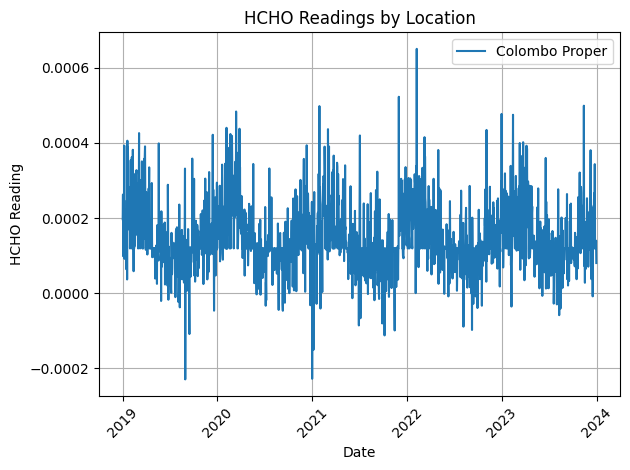

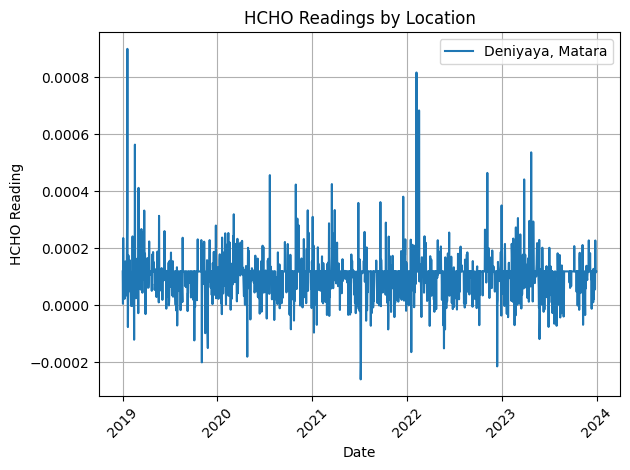

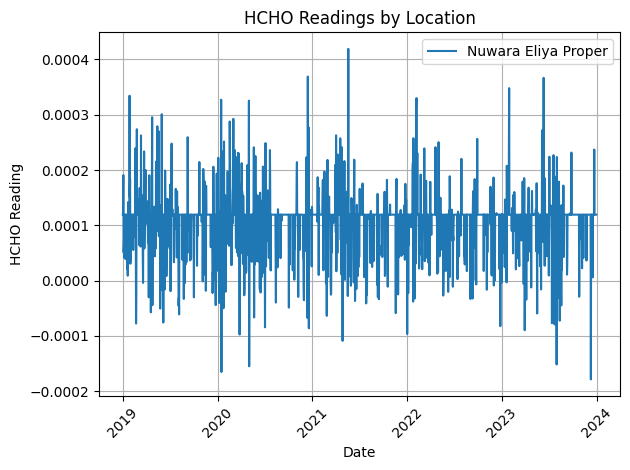

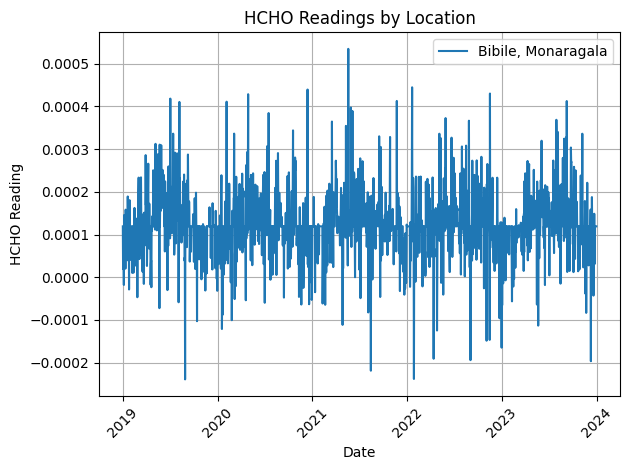

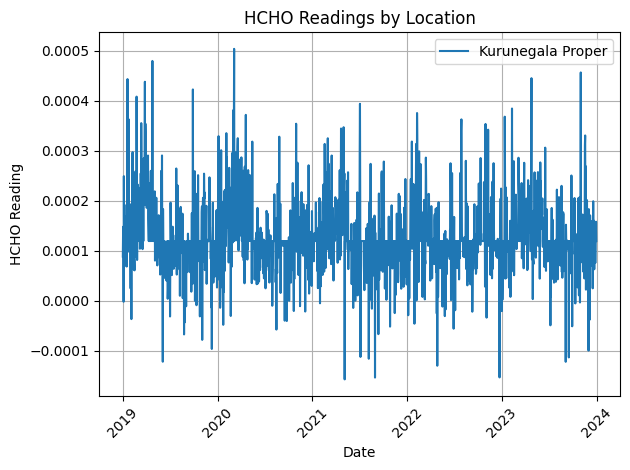

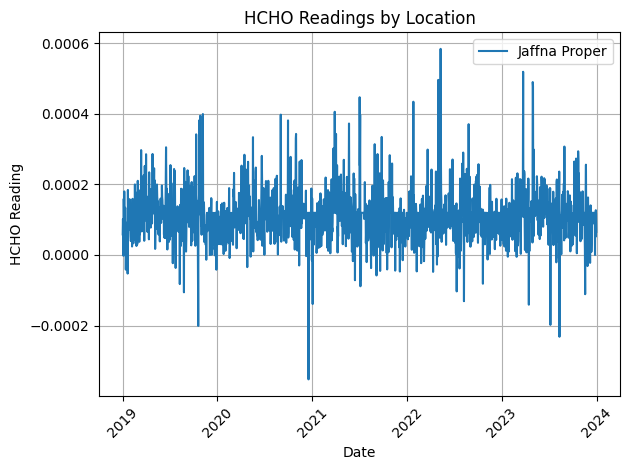

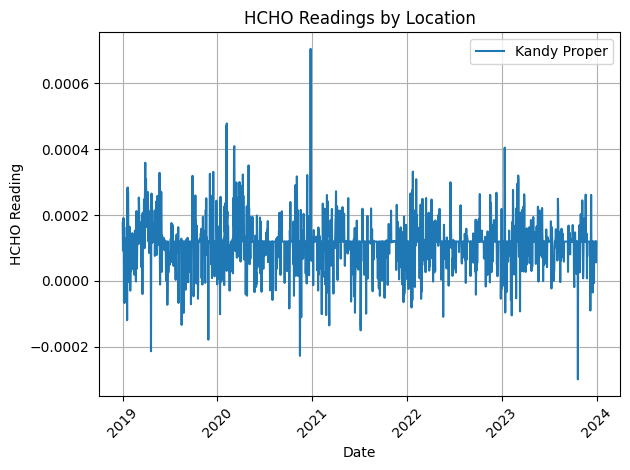

In [242]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
df_pandas = df_spark.toPandas()

# Plot HCHO readings for each location
locations = df_pandas['Location'].unique()
for location in locations:
    data_location = df_pandas[df_pandas['Location'] == location]
    plt.plot(data_location['Current Date'], data_location['HCHO Reading'], label=location)

    # Customize plot
    plt.xlabel('Date')
    plt.ylabel('HCHO Reading')
    plt.title('HCHO Readings by Location')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()

In [243]:
# Convert 'Current Date' column to datetime format
df_pandas['Current Date'] = pd.to_datetime(df_pandas['Current Date'])

# Extract month from 'Current Date' column
df_pandas['Month'] = df_pandas['Current Date'].dt.month

# Display the first few rows to verify the changes
print(df_pandas.head())

   HCHO Reading        Location Current Date   Next Date  Month
0      0.000197  Colombo Proper   2019-01-01  2019-01-02      1
1      0.000263  Colombo Proper   2019-01-02  2019-01-03      1
2      0.000099  Colombo Proper   2019-01-03  2019-01-04      1
3      0.000210  Colombo Proper   2019-01-04  2019-01-05      1
4      0.000179  Colombo Proper   2019-01-05  2019-01-06      1


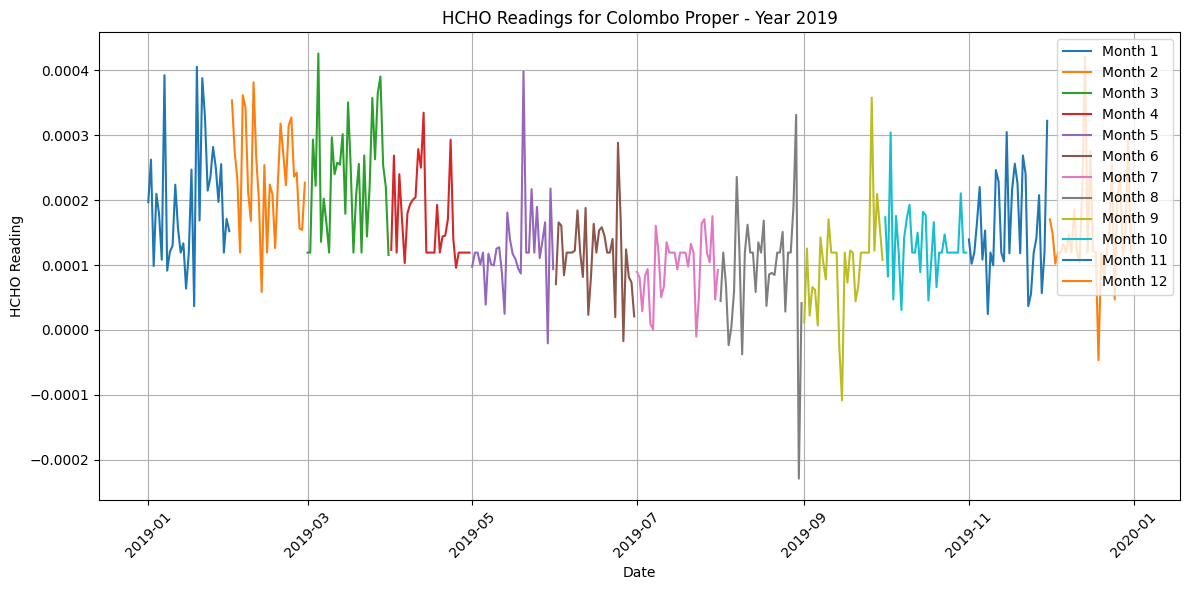

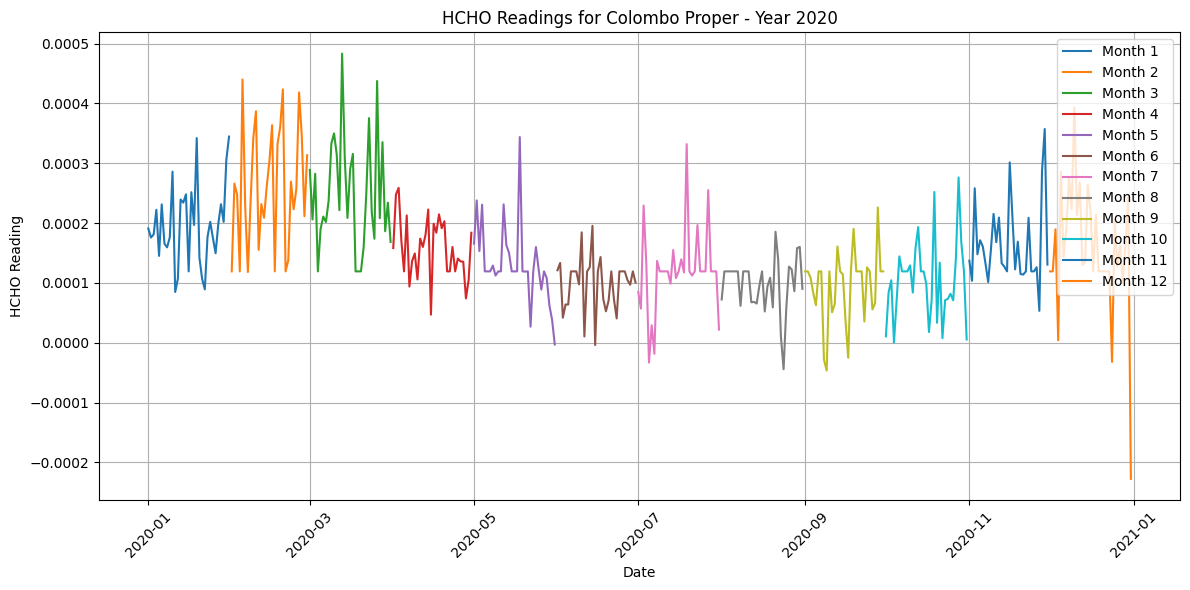

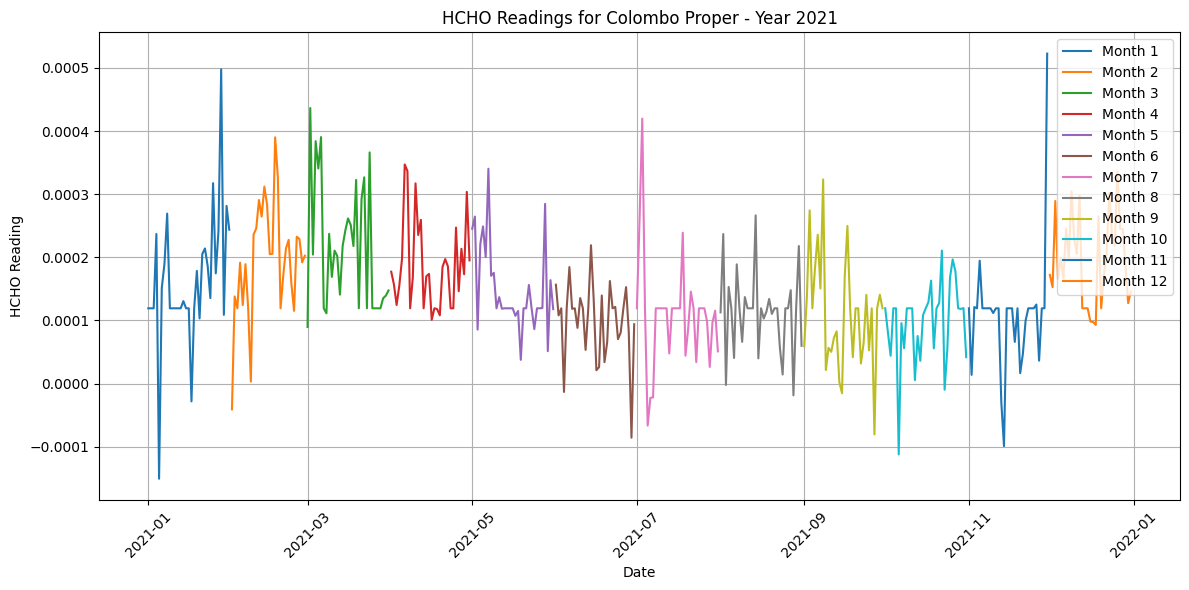

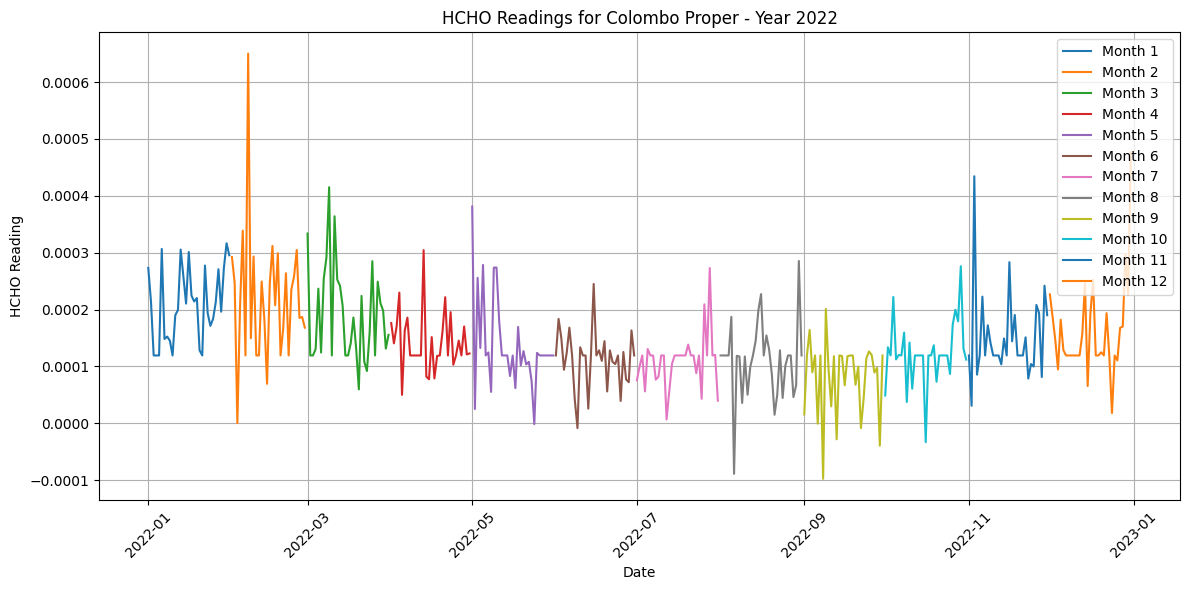

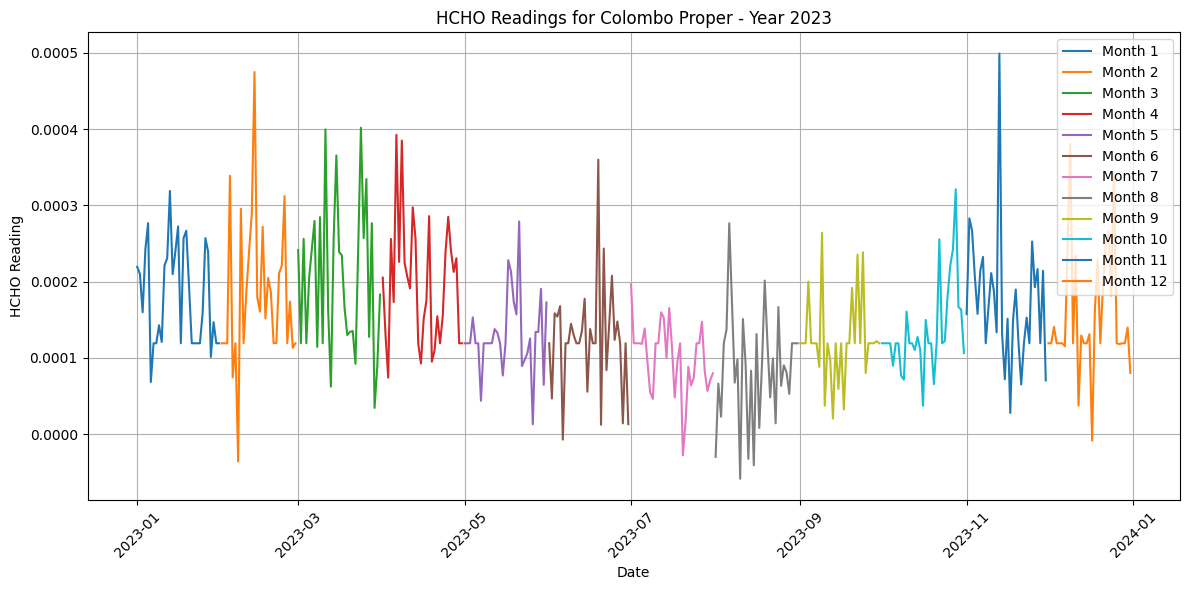

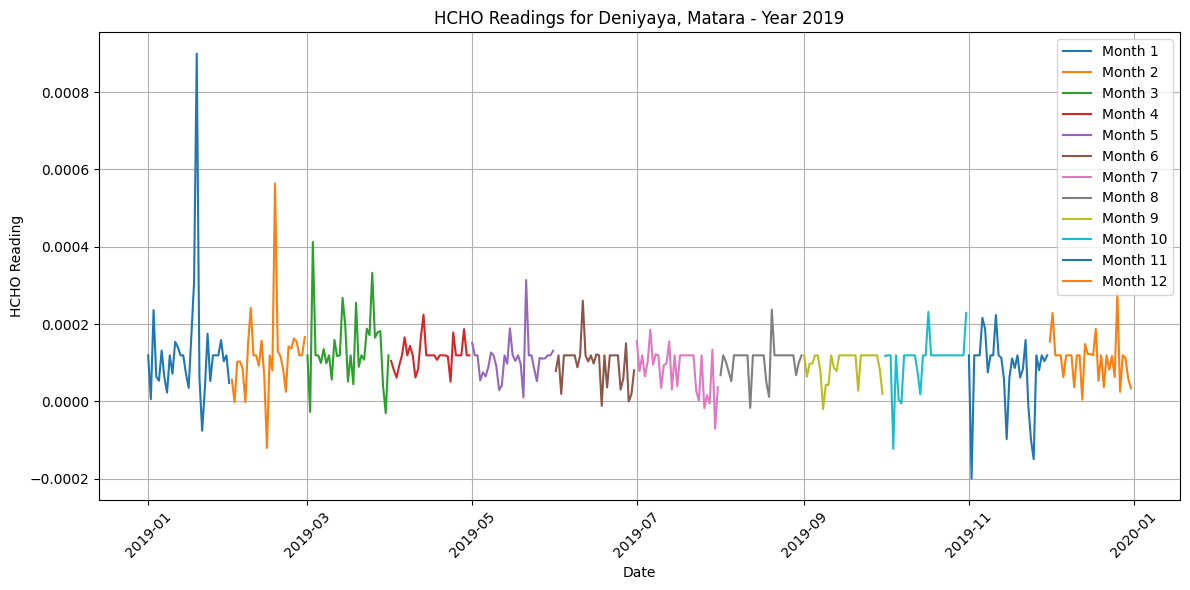

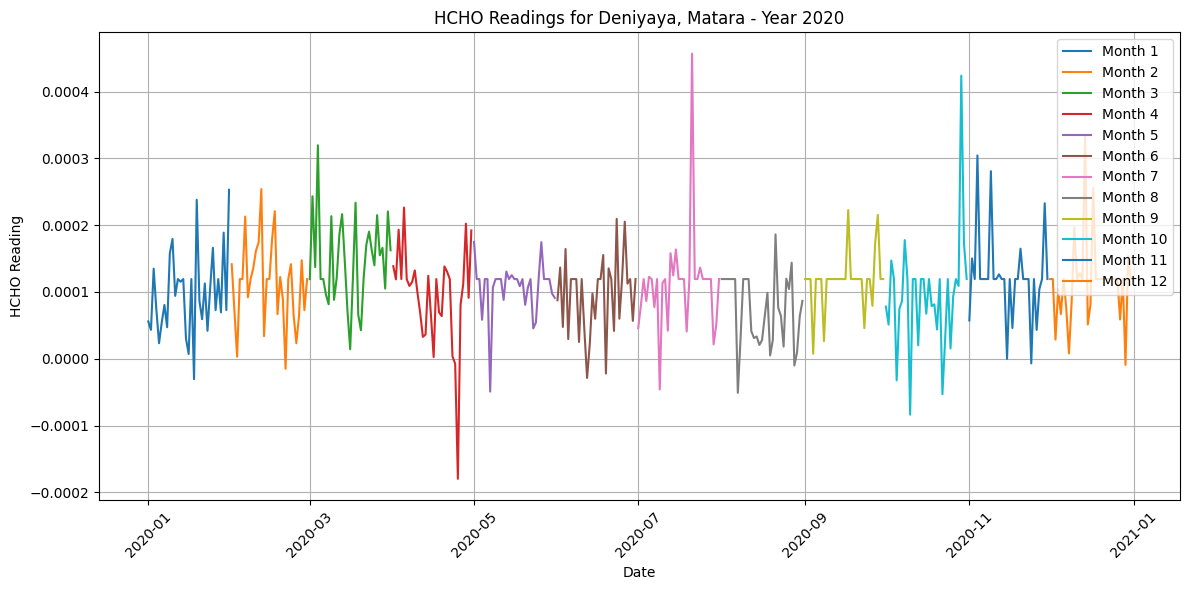

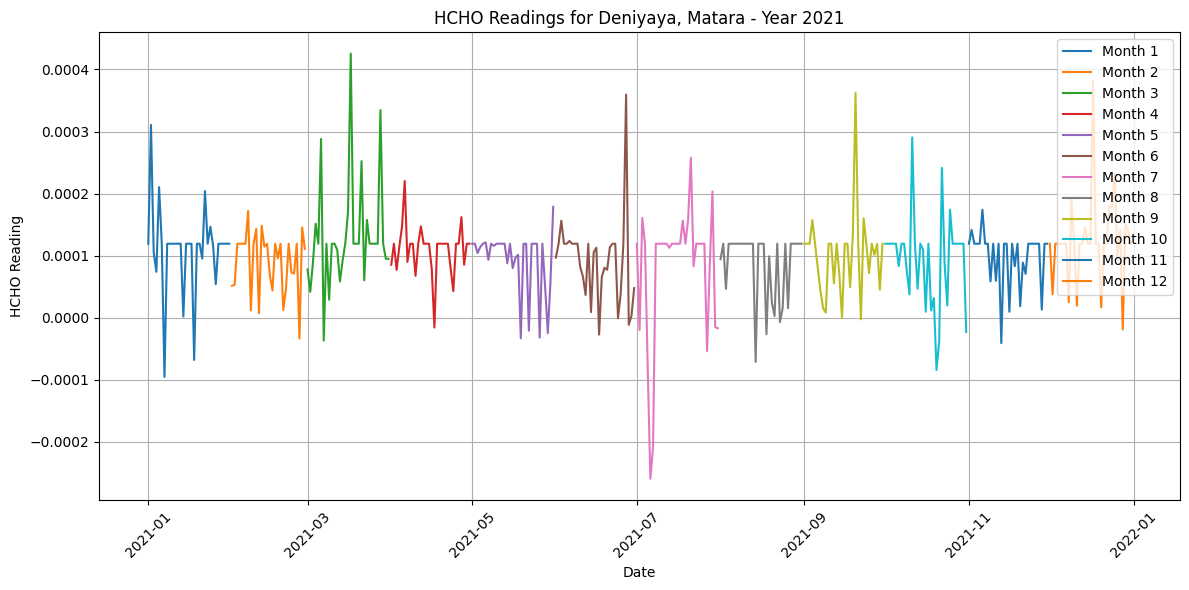

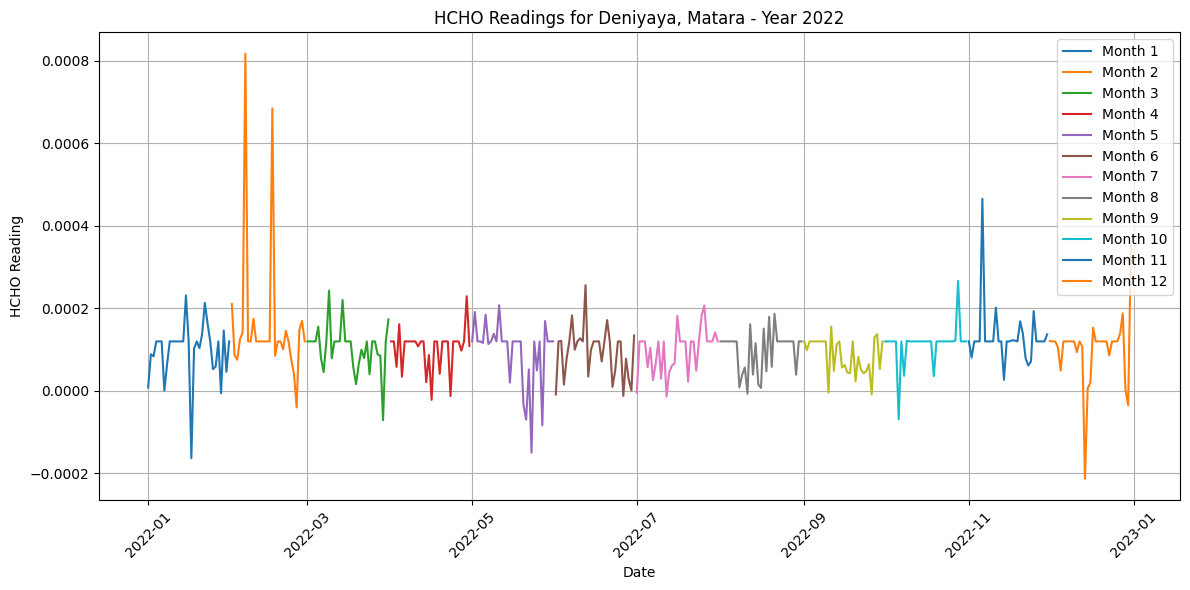

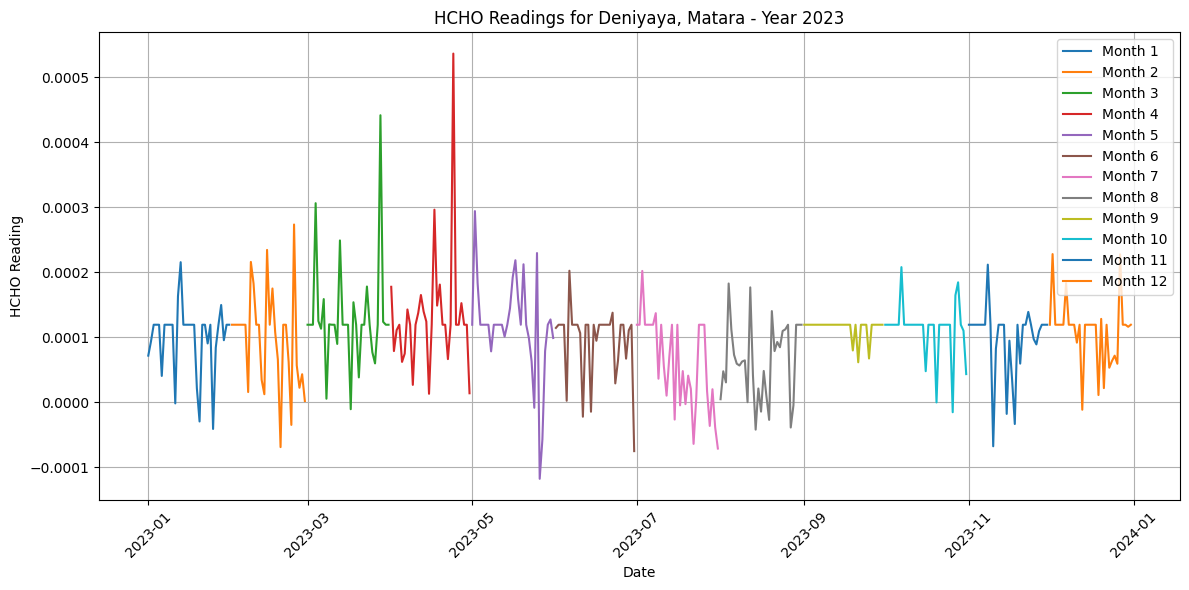

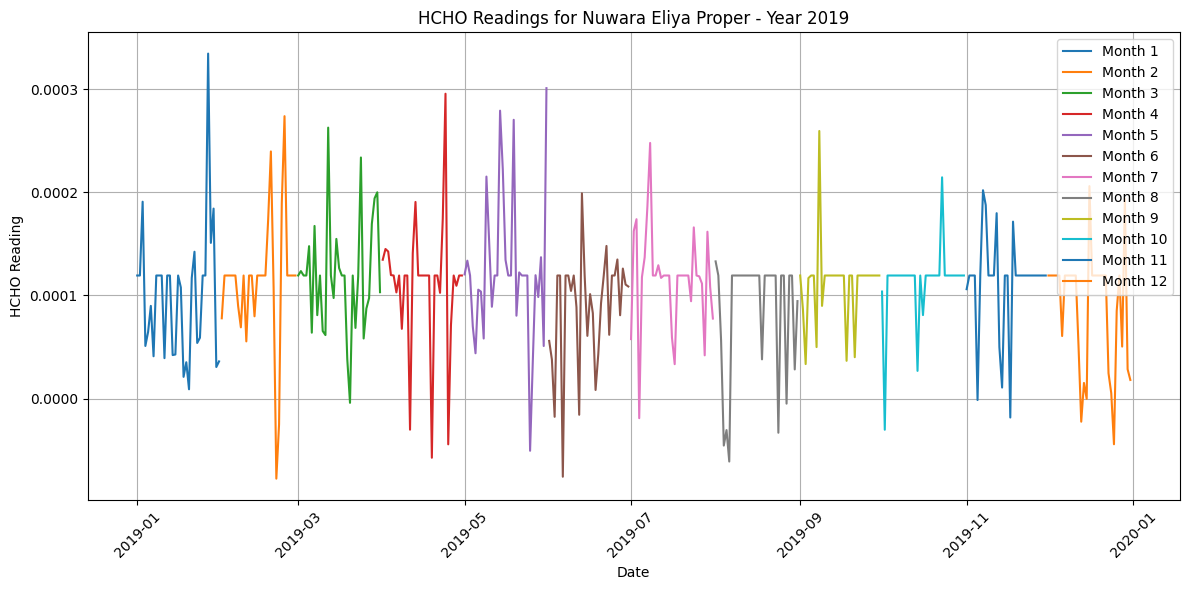

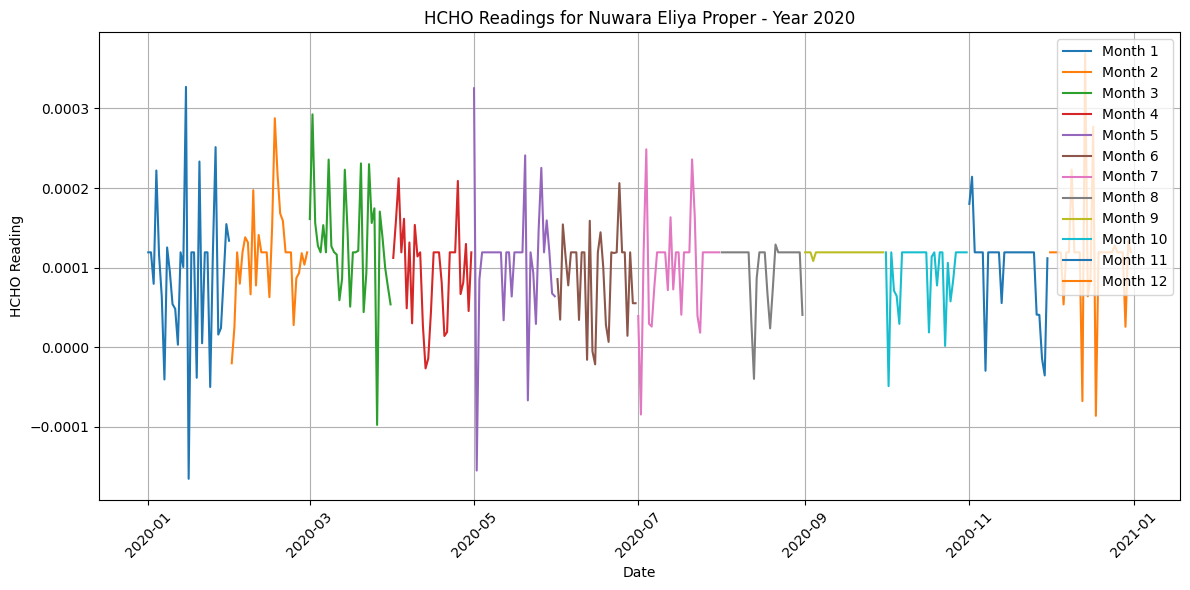

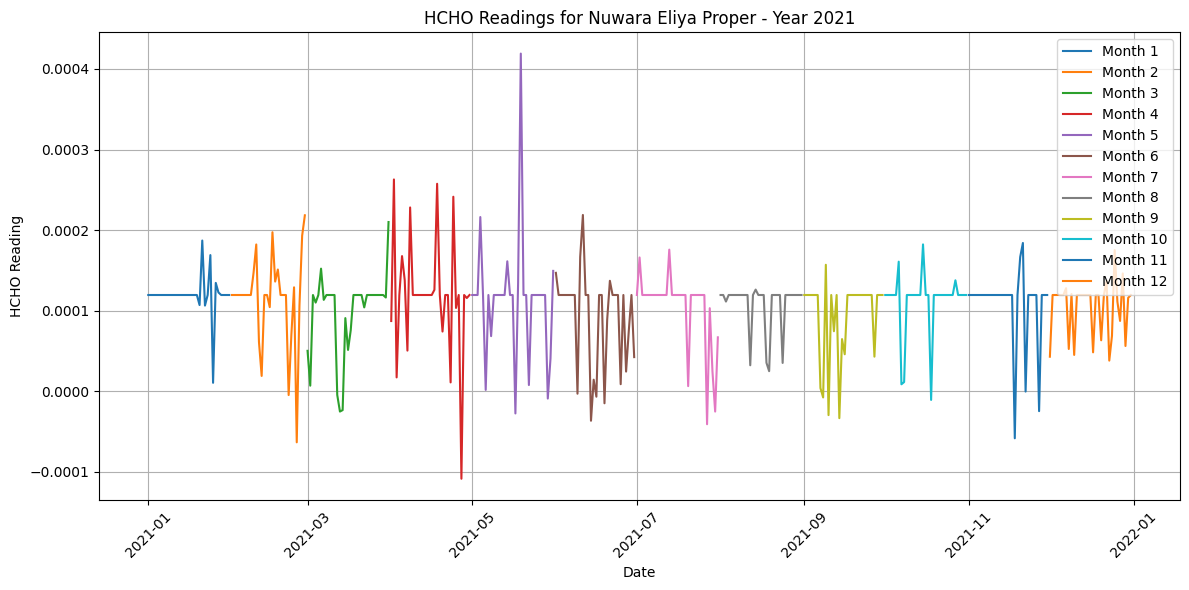

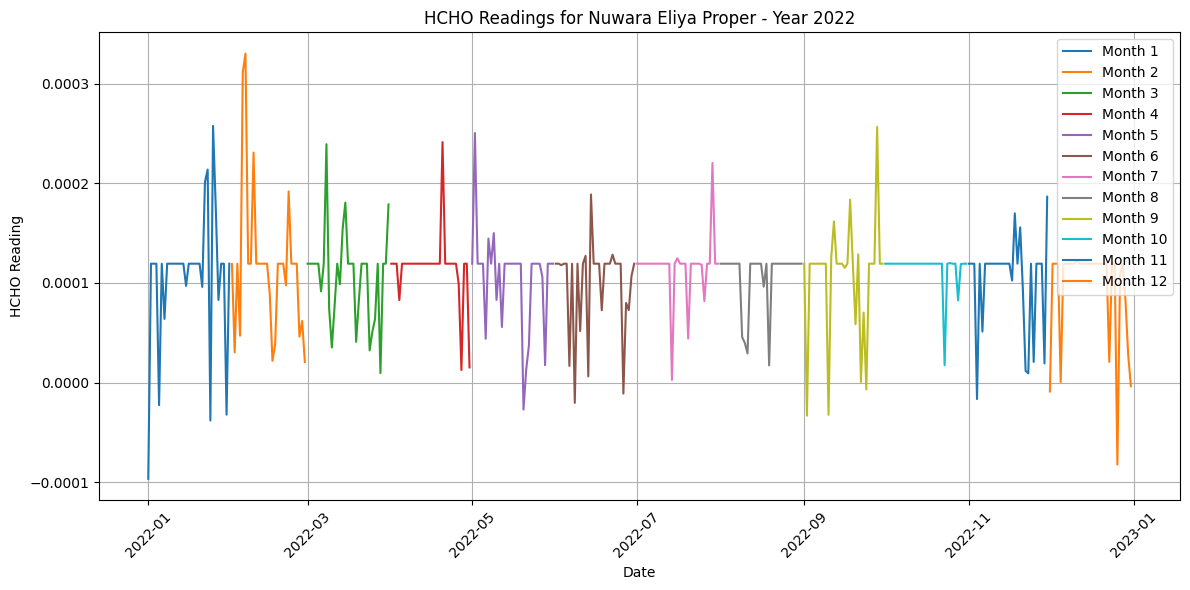

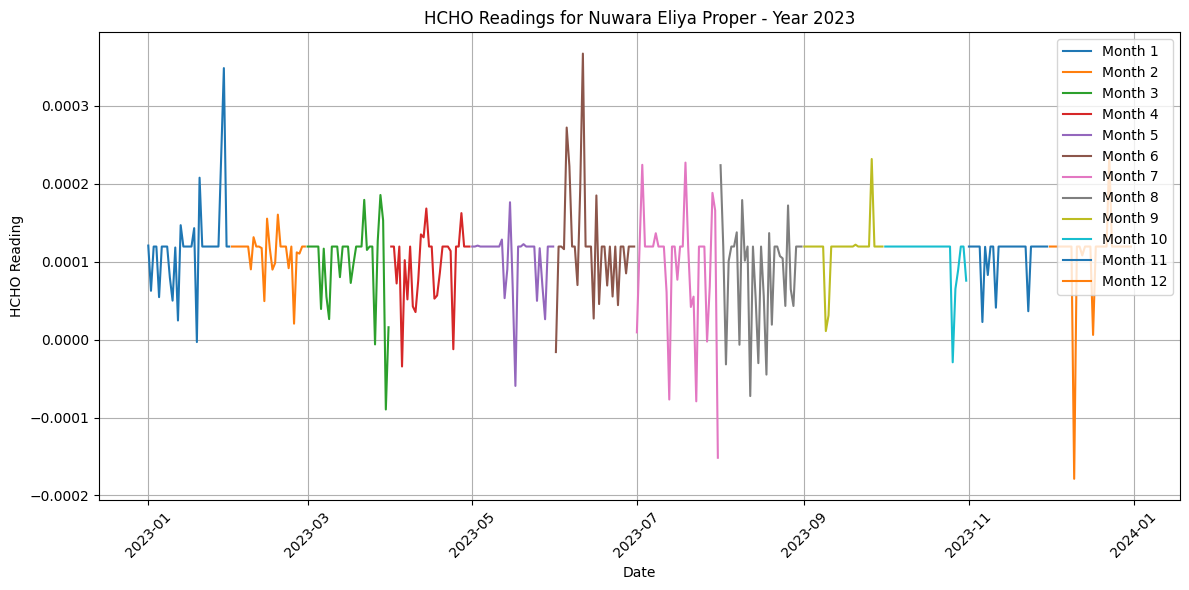

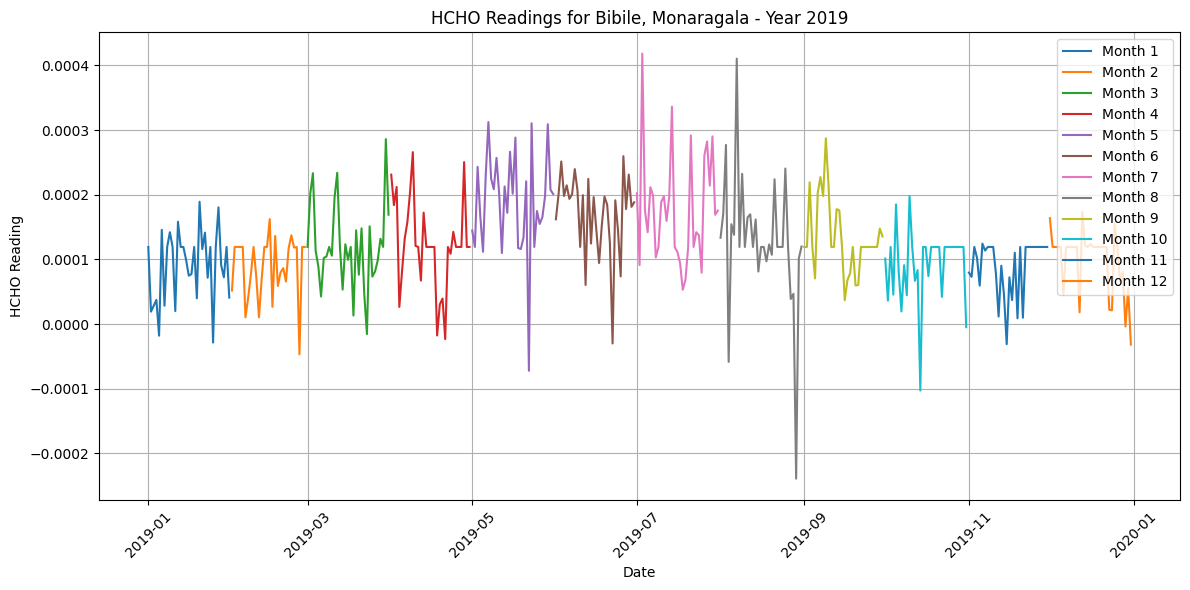

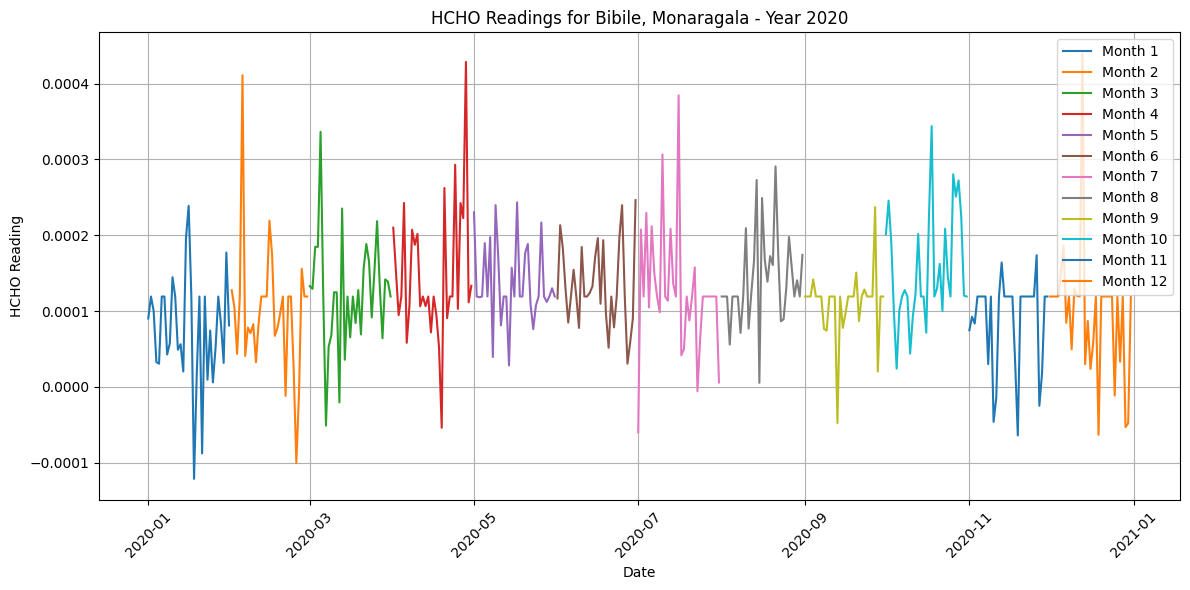

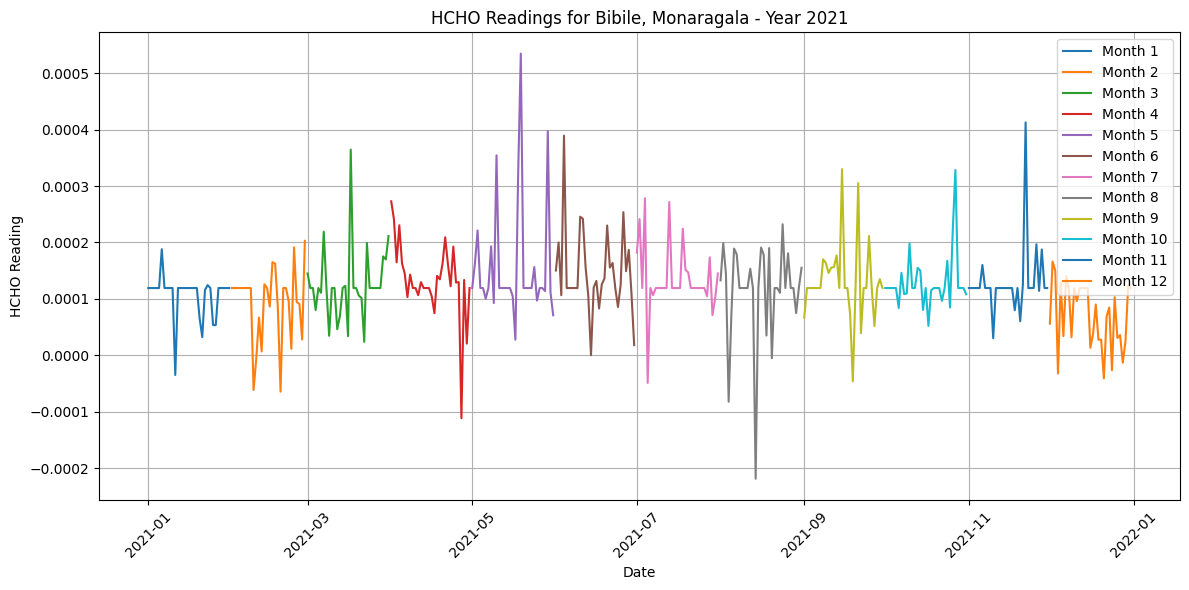

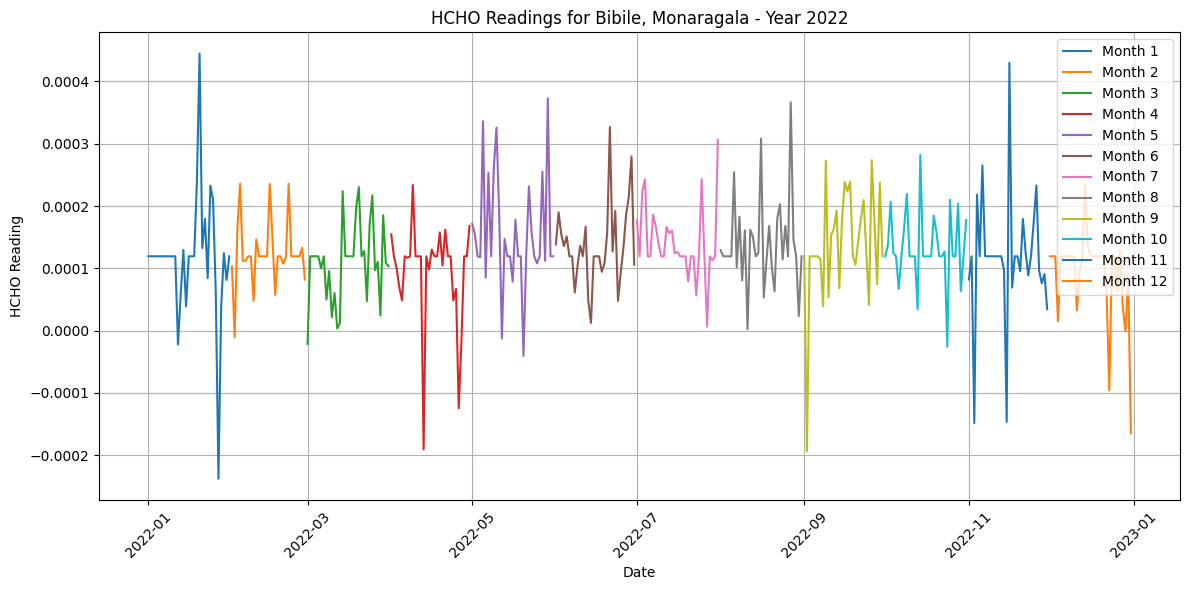

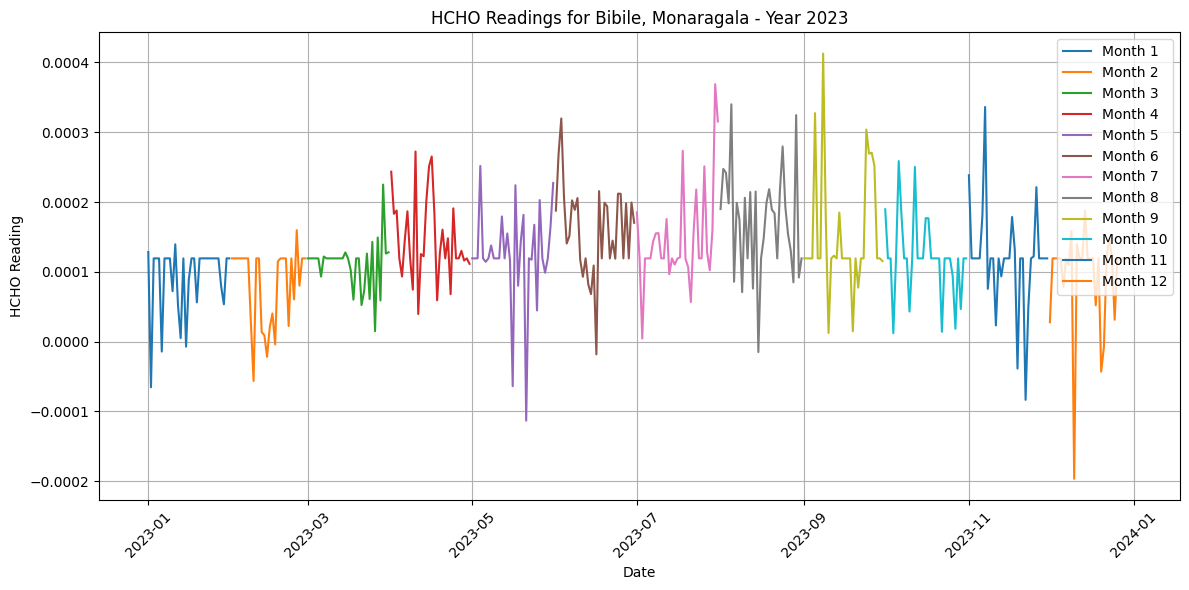

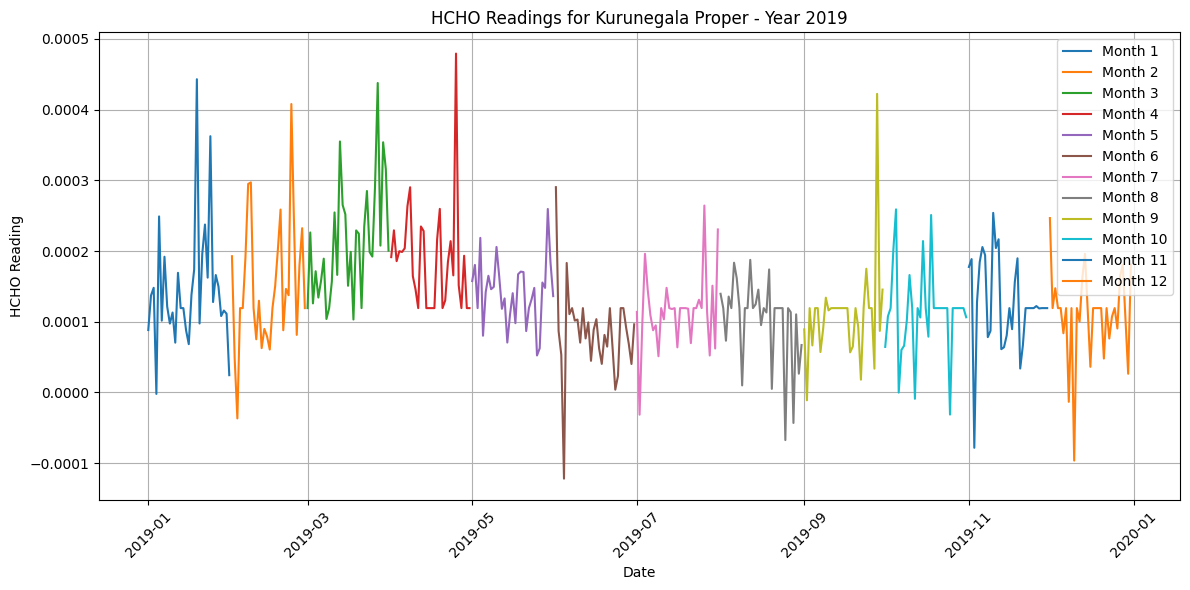

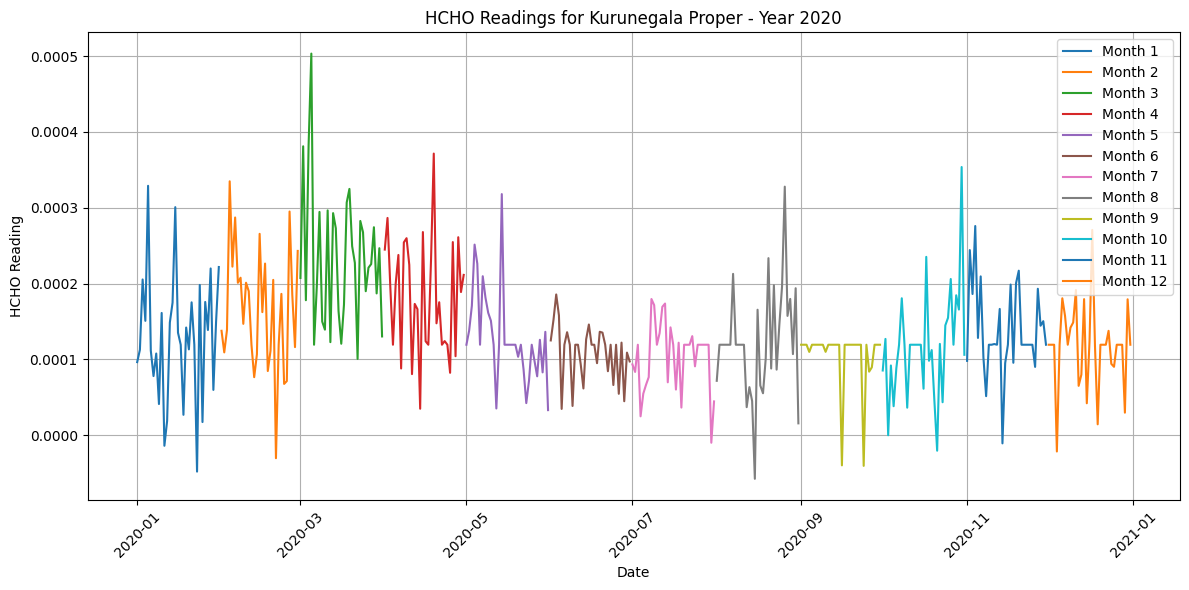

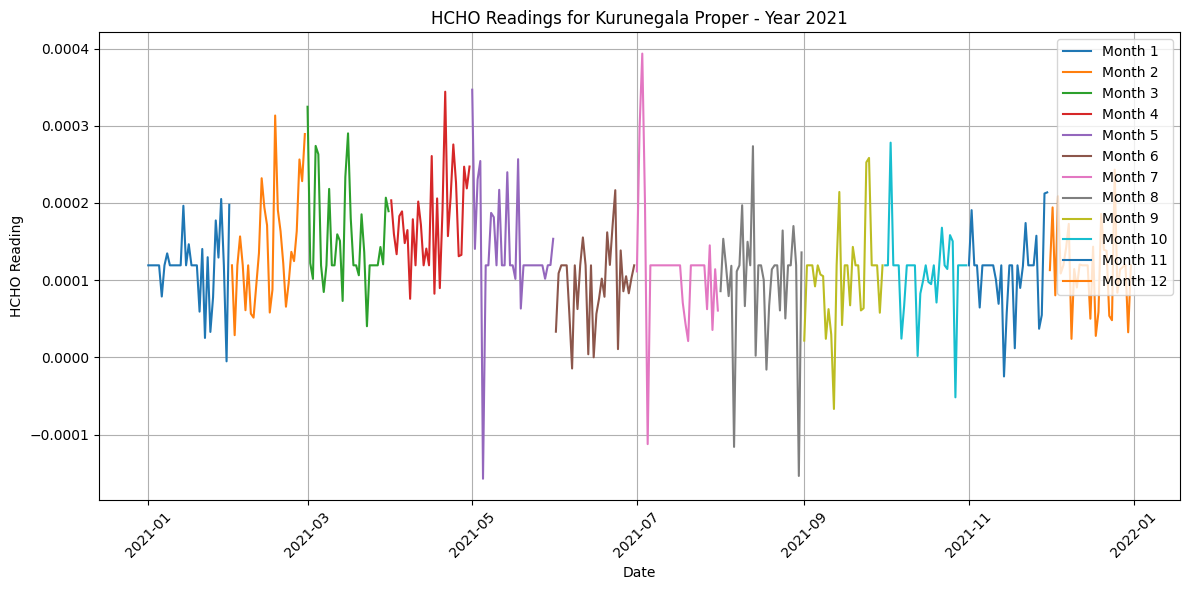

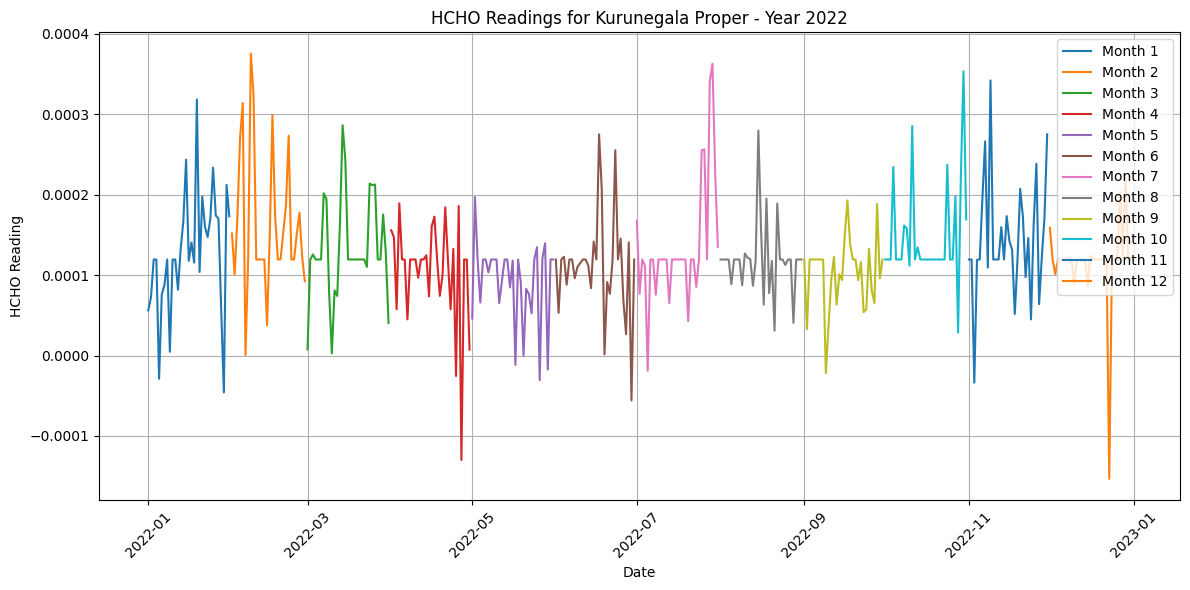

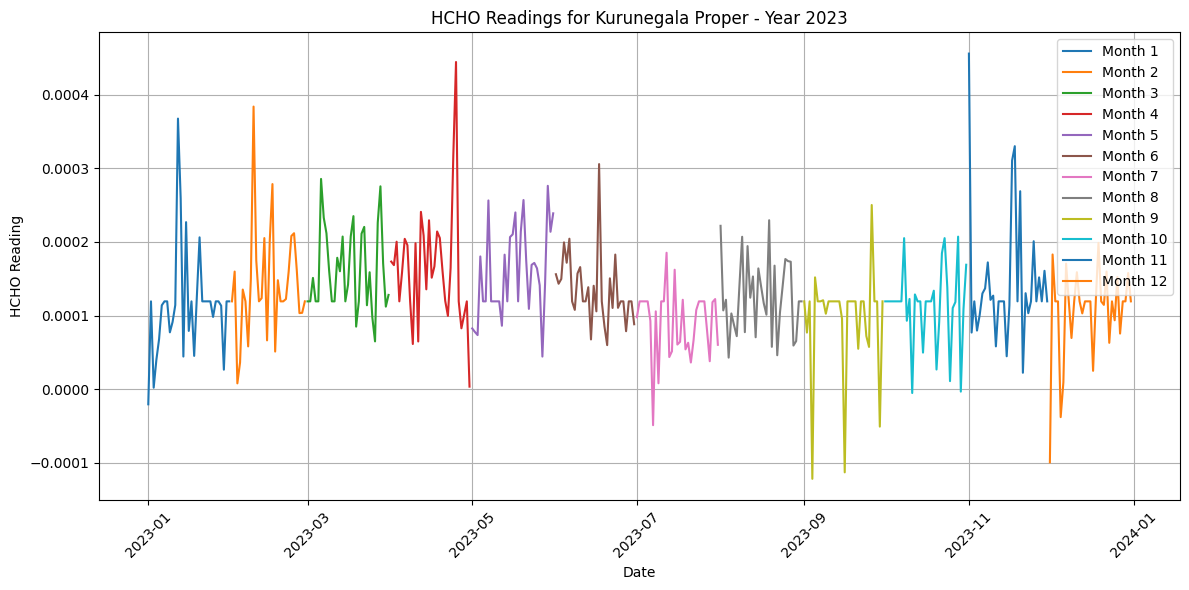

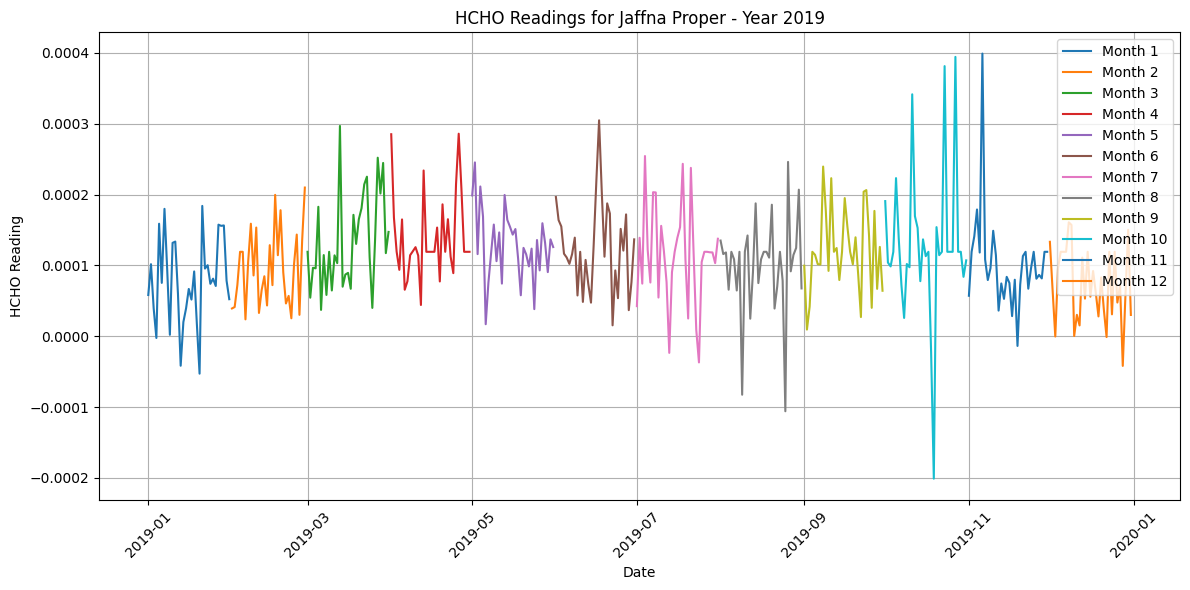

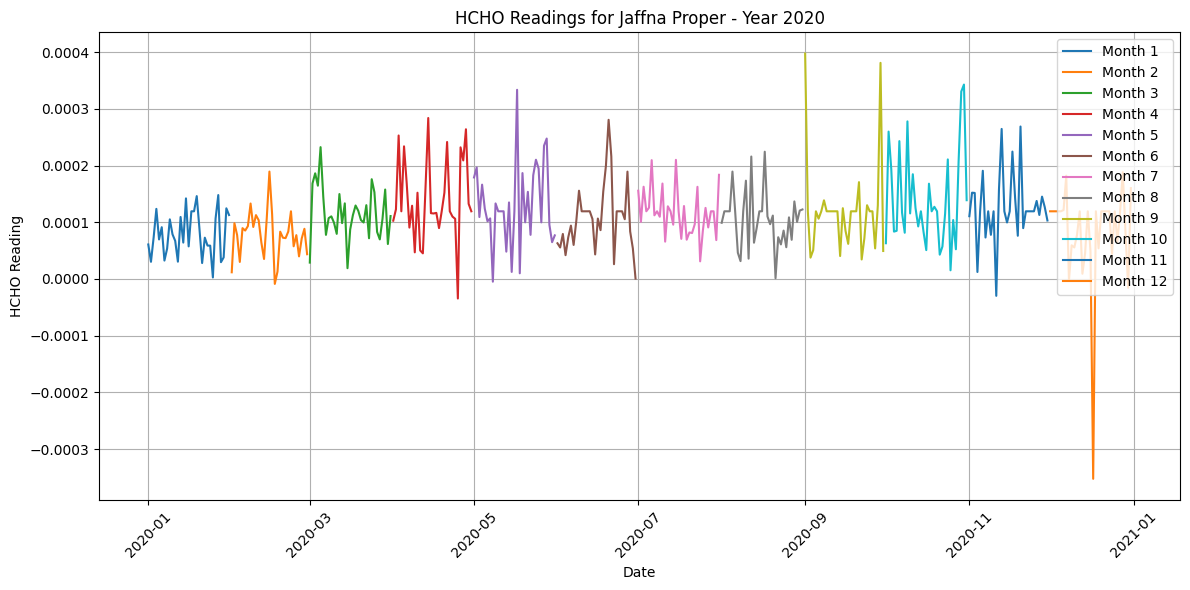

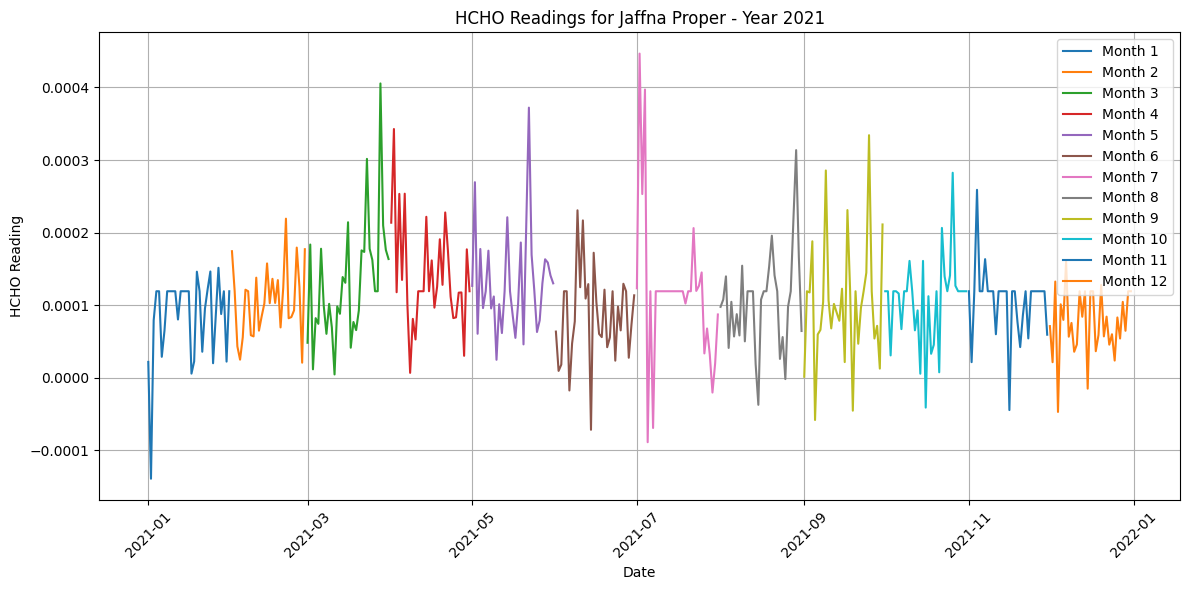

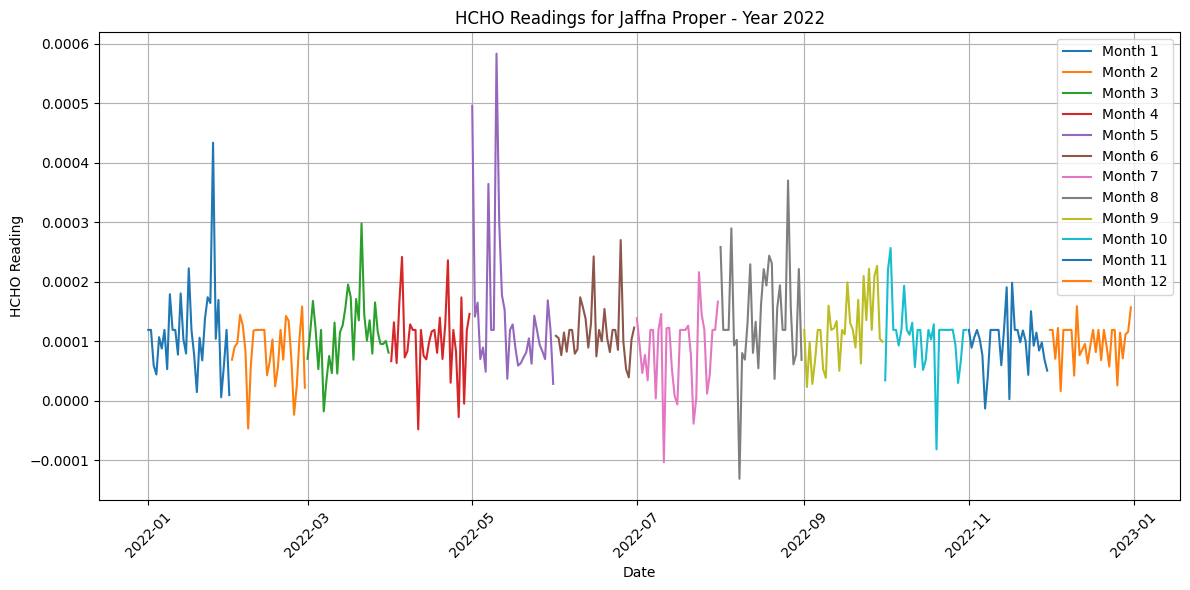

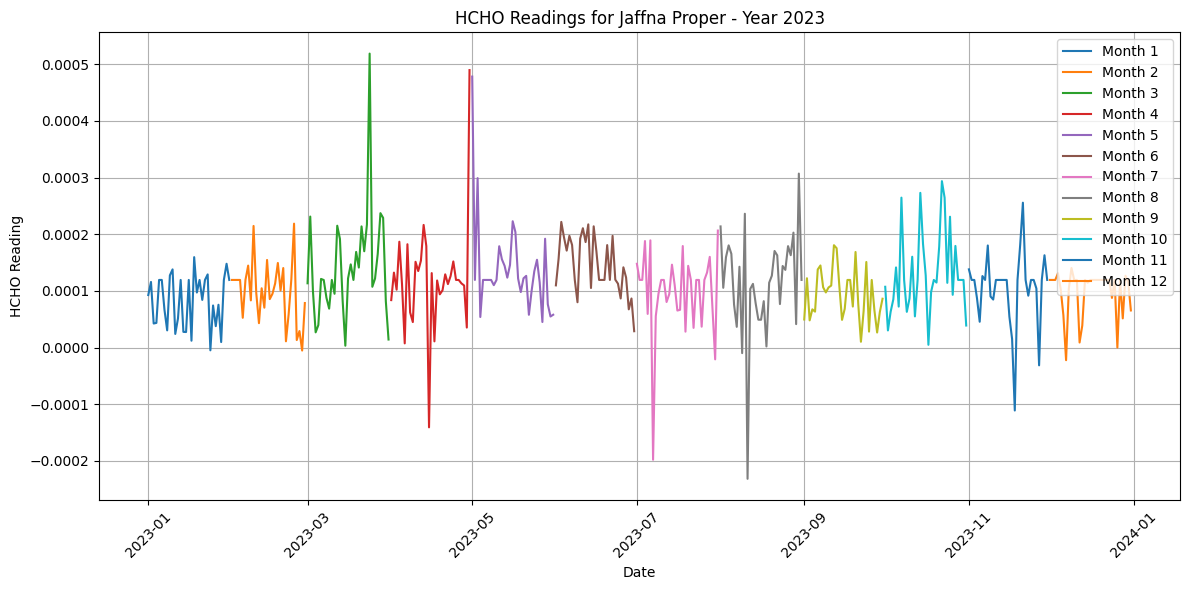

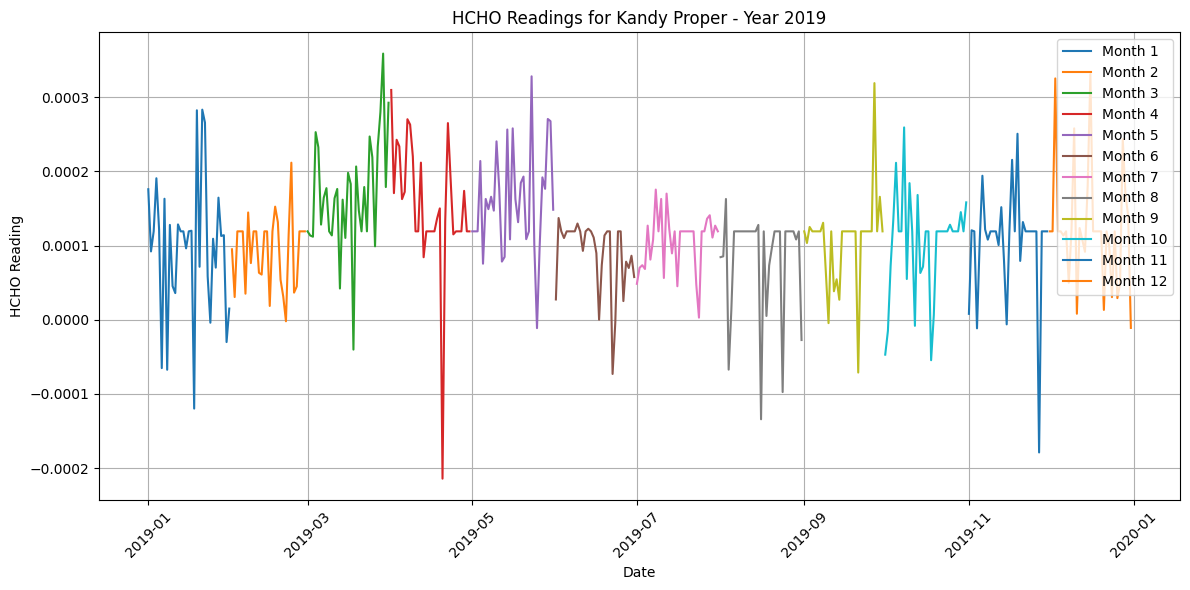

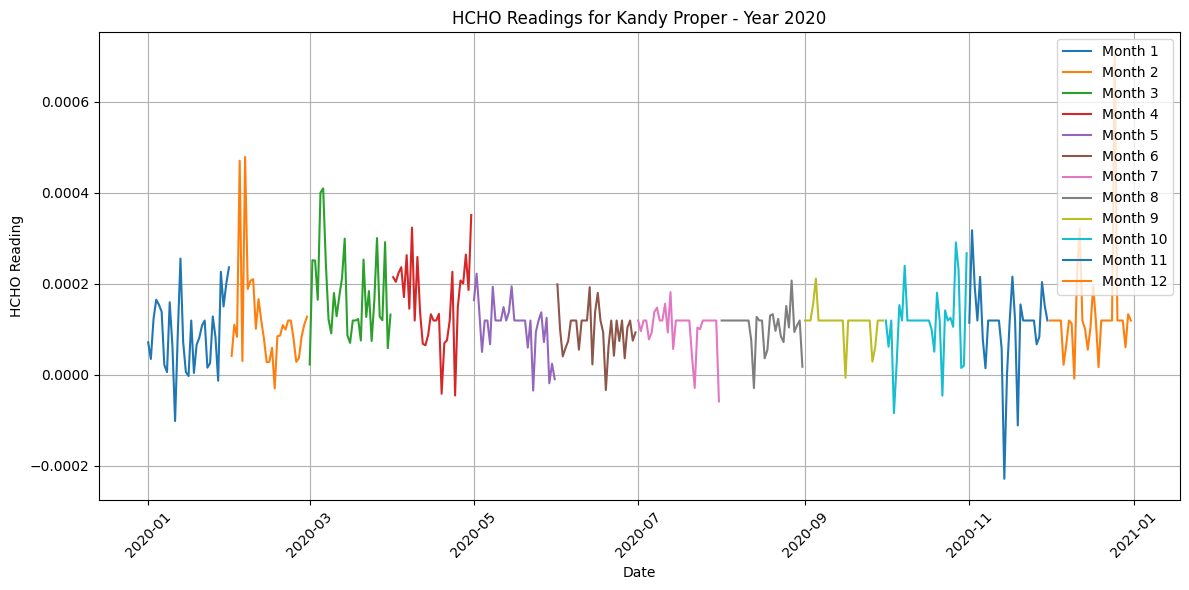

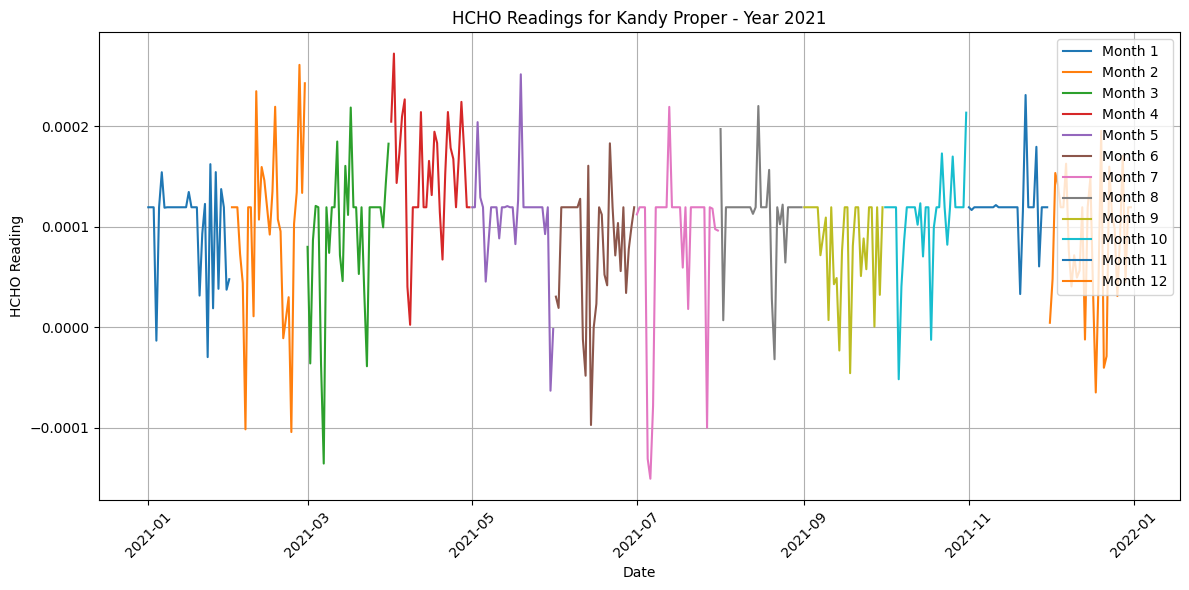

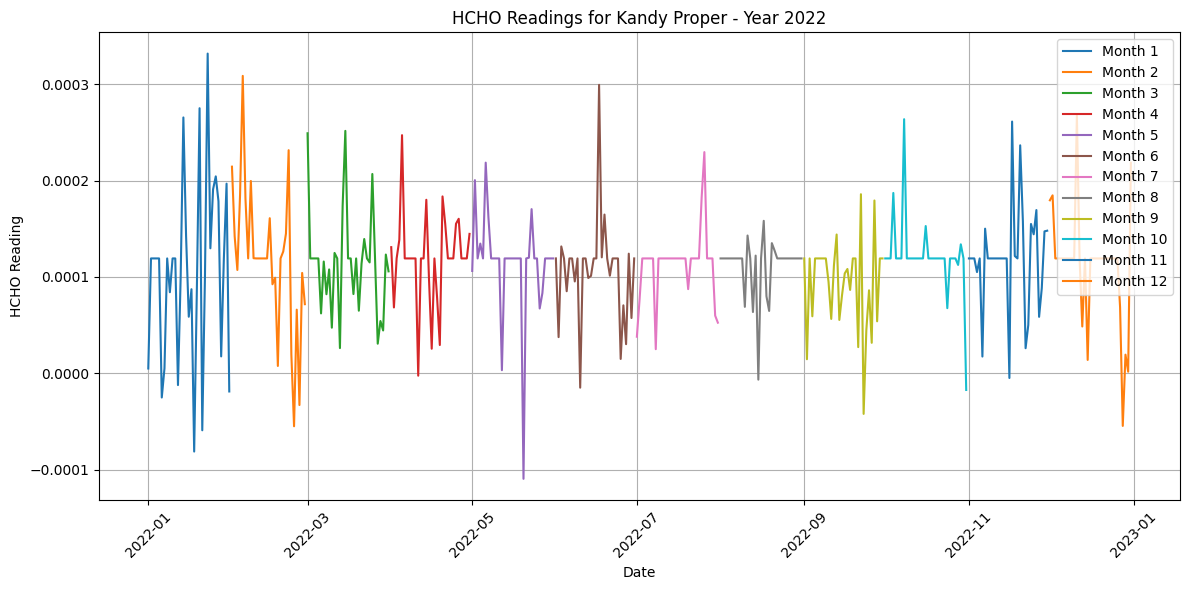

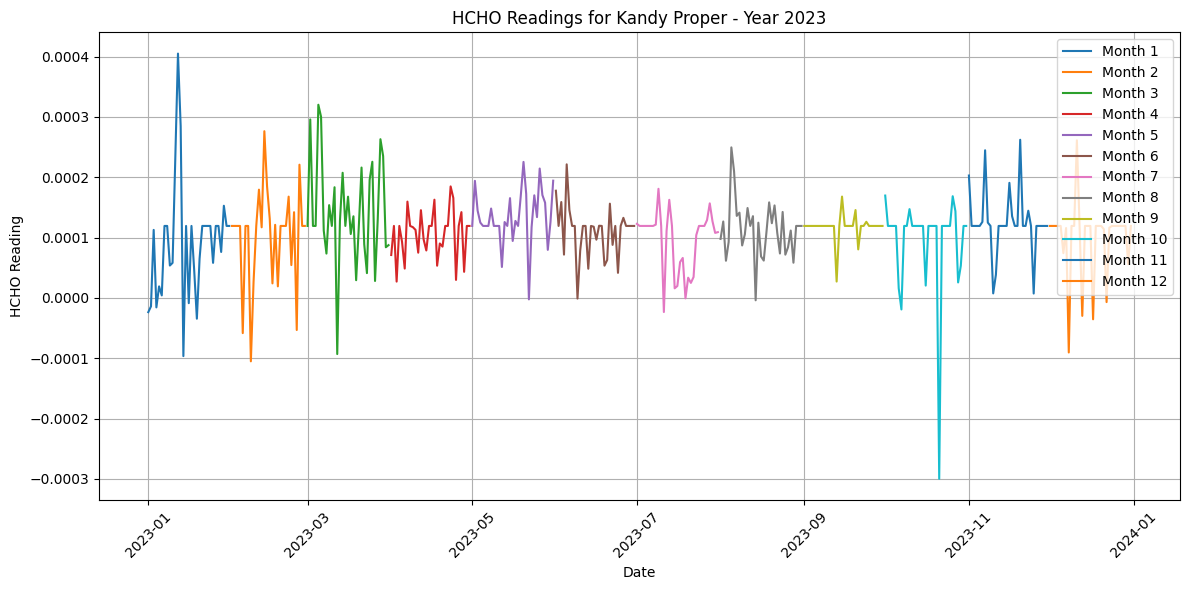

In [244]:
# Plot HCHO readings for each location and each month
locations = df_pandas['Location'].unique()
months = sorted(df_pandas['Month'].unique())
years = df_pandas['Current Date'].dt.year.unique()

for location in locations:
    for year in years:
        plt.figure(figsize=(12, 6))  # Set the width and height of the plot
        plt.title(f'HCHO Readings for {location} - Year {year}')  # Set the title of the plot

        for month in months:
            data_location_month_year = df_pandas[(df_pandas['Location'] == location) &
                                                  (df_pandas['Month'] == month) &
                                                  (df_pandas['Current Date'].dt.year == year)]
            if not data_location_month_year.empty:
                plt.plot(data_location_month_year['Current Date'], data_location_month_year['HCHO Reading'],
                         label=f"Month {month}")

        # Customize plot
        plt.xlabel('Date')
        plt.ylabel('HCHO Reading')
        plt.legend(loc='upper right')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()

        # Show plot
        plt.show()


In [245]:
from pyspark.sql.functions import mean, col

# Calculate the mean HCHO reading for each location
mean_hcho_by_location = df_spark.groupBy('Location').agg(mean('HCHO Reading').alias('Mean HCHO Reading'))

# Rank locations based on mean HCHO reading (descending order)
ranked_locations = mean_hcho_by_location.orderBy(col('Mean HCHO Reading').desc())

# Show the ranked locations
ranked_locations.show()

+-------------------+--------------------+
|           Location|   Mean HCHO Reading|
+-------------------+--------------------+
|     Colombo Proper|1.480916996036323...|
|  Kurunegala Proper|1.292407039248092...|
| Bibile, Monaragala|1.237086665854354...|
|       Kandy Proper|1.119791209506632E-4|
|      Jaffna Proper|1.109013636756122...|
|Nuwara Eliya Proper|1.065550795445532...|
|   Deniyaya, Matara|1.044686072749091...|
+-------------------+--------------------+



###**Altitude ?**

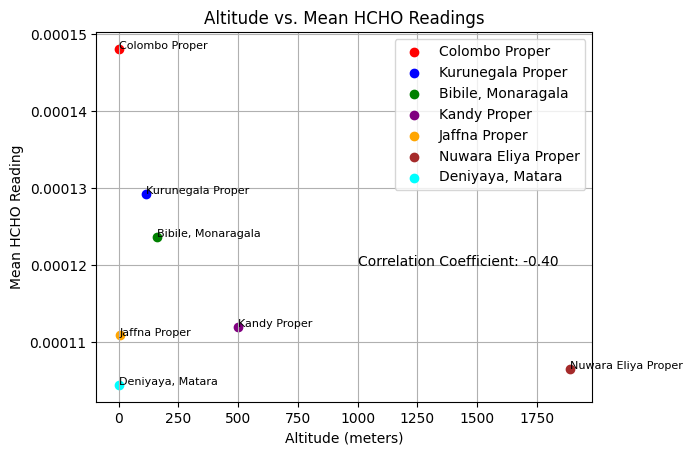

In [246]:
import numpy as np
import matplotlib.pyplot as plt

# Altitude data (in meters above sea level) for each location
location_altitude_meters = {
    "Colombo Proper": 1,
    "Kurunegala Proper": 116,
    "Bibile, Monaragala": 161,
    "Kandy Proper": 500,
    "Jaffna Proper": 5,
    "Nuwara Eliya Proper": 1889,
    "Deniyaya, Matara": 2
}

# Mean HCHO reading data for each location
mean_hcho_readings = {
    "Colombo Proper": 1.480916996036323e-4,
    "Kurunegala Proper": 1.292407039248092e-4,
    "Bibile, Monaragala": 1.237086665854354e-4,
    "Kandy Proper": 1.119791209506632e-4,
    "Jaffna Proper": 1.109013636756122e-4,
    "Nuwara Eliya Proper": 1.065550795445532e-4,
    "Deniyaya, Matara": 1.044686072749091e-4
}

# Convert dictionaries to arrays for easier computation
altitudes = np.array(list(location_altitude_meters.values()))
hcho_readings = np.array(list(mean_hcho_readings.values()))
cities = list(location_altitude_meters.keys())  # List of city names

# Calculate correlation coefficient between altitude and mean HCHO readings
correlation_coefficient = np.corrcoef(altitudes, hcho_readings)[0, 1]

# Define colors for each city
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'cyan']

# Plot altitude vs. mean HCHO readings with labeled points
for i in range(len(altitudes)):
    plt.scatter(altitudes[i], hcho_readings[i], color=colors[i], label=cities[i])
    plt.text(altitudes[i], hcho_readings[i], cities[i], fontsize=8)

plt.title('Altitude vs. Mean HCHO Readings')
plt.xlabel('Altitude (meters)')
plt.ylabel('Mean HCHO Reading')
plt.grid(True)

# Add legend
plt.legend(loc='upper right')

# Add correlation coefficient to the plot
plt.text(1000, 1.2e-4, f'Correlation Coefficient: {correlation_coefficient:.2f}', fontsize=10, color='black')

# Show plot
plt.show()


###**Population Density ?**

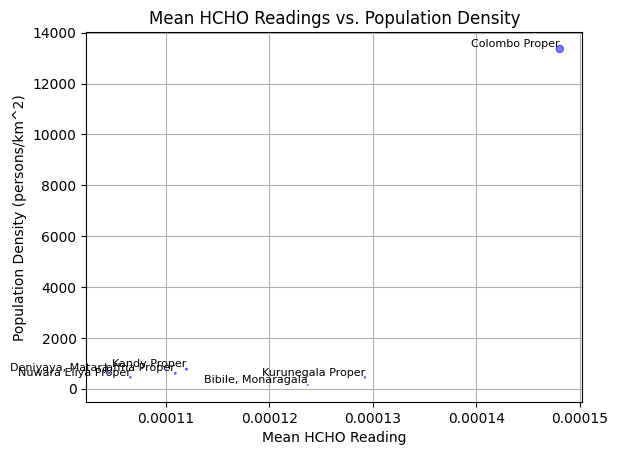

In [247]:
import numpy as np
import matplotlib.pyplot as plt

# Mean HCHO reading data for each location
mean_hcho_readings = {
    "Colombo Proper": 1.480916996036323e-4,
    "Kurunegala Proper": 1.292407039248092e-4,
    "Bibile, Monaragala": 1.237086665854354e-4,
    "Kandy Proper": 1.119791209506632e-4,
    "Jaffna Proper": 1.109013636756122e-4,
    "Nuwara Eliya Proper": 1.065550795445532e-4,
    "Deniyaya, Matara": 1.044686072749091e-4
}

# Population density data for each location (persons per square kilometer)
population_density = {
    "Colombo Proper": 13364,
    "Kurunegala Proper": 448.02,
    "Bibile, Monaragala": 152,
    "Kandy Proper": 773.2,
    "Jaffna Proper": 610.73,
    "Nuwara Eliya Proper": 448.02,
    "Deniyaya, Matara": 634.59
}

# Convert dictionaries to arrays for easier computation
hcho_readings = np.array(list(mean_hcho_readings.values()))
population_densities = np.array(list(population_density.values()))
cities = list(mean_hcho_readings.keys())  # List of city names

# Define marker sizes based on population density
marker_sizes = population_densities / 500  # Adjust scale for better visualization

# Plot mean HCHO readings vs. population density with marker size
plt.scatter(hcho_readings, population_densities, s=marker_sizes, c='blue', alpha=0.5)

# Display city names separately
for i, city in enumerate(cities):
    plt.text(hcho_readings[i], population_densities[i], city, fontsize=8, ha='right', va='bottom')

plt.title('Mean HCHO Readings vs. Population Density')
plt.xlabel('Mean HCHO Reading')
plt.ylabel('Population Density (persons/km^2)')
plt.grid(True)

# Show plot
plt.show()


#**3. Model Development**

In [248]:
df_pandas = df_spark.toPandas()
columns_list = df_pandas.columns
print(columns_list)

Index(['HCHO Reading', 'Location', 'Current Date', 'Next Date'], dtype='object')


In [249]:
# df_pandas.plot()

In [250]:
# from statsmodels.tsa.stattools import adfuller

# test_result=adfuller(df_pandas['HCHO Reading'])

# def adfuller_test(HCHO_Reading):

#     result=adfuller(HCHO_Reading)
#     labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

#     for value,label in zip(result,labels):
#         print(label+' : '+str(value) )
#     if result[1] <= 0.05:
#         print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
#     else:
#         print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [251]:
# adfuller_test(df_pandas['HCHO Reading'])

In [252]:
# df_pandas['HCHO Reading Difference'] = df_pandas['HCHO Reading'] - df_pandas['HCHO Reading'].shift(1)
# df_pandas['HCHO Reading'].shift(1)

In [253]:
# df_pandas['HCHO Reading Difference'] = df_pandas['HCHO Reading'] - df_pandas['HCHO Reading'].shift(12)

In [254]:
# df_pandas.head()

In [255]:
# adfuller_test(df_pandas['HCHO Reading Difference'].dropna())

In [256]:
# # Increase the width of the plot
# plt.figure(figsize=(16, 6))  # Adjust the width and height as needed
# df_pandas['HCHO Reading Difference'].plot()

# # Optionally, add titles and labels
# plt.title('HCHO Reading Difference Plot')
# plt.xlabel('X-axis Label')
# plt.ylabel('Y-axis Label')

# # Show the plot
# plt.show()

In [257]:
# from pandas.plotting import autocorrelation_plot

# # Plot the autocorrelation plot
# autocorrelation_plot(df_pandas['HCHO Reading Difference'])
# plt.show()


In [258]:
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# import statsmodels.api as sm

# fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(df_pandas['HCHO Reading Difference'].iloc[13:],lags=40,ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(df_pandas['HCHO Reading Difference'].iloc[13:],lags=40,ax=ax2)

In [259]:
# # For non-seasonal data
# #p=1, d=1, q=0 or 1
# from statsmodels.tsa.arima.model import ARIMA

# model=ARIMA(df_pandas['HCHO Reading'],order=(1,1,1))
# model_fit=model.fit()

In [260]:
# model_fit.summary()

In [261]:
# df_pandas['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
# df_pandas[['HCHO Reading','forecast']].plot(figsize=(12,8))

In [262]:
# model=sm.tsa.statespace.SARIMAX(df_pandas['HCHO Reading'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
# results=model.fit()

In [263]:

# df_pandas['forecast']=results.predict(start=90,end=103,dynamic=True)
# df_pandas[['HCHO Reading','forecast']].plot(figsize=(12,8))

In [264]:
# # Convert 'Month' column to datetime if not already
# df_pandas['Current Date'] = pd.to_datetime(df_pandas['Current Date'])

# # Set 'Month' as the index of the DataFrame
# df_pandas.set_index('Current Date', inplace=True)


# from pandas.tseries.offsets import DateOffset

# # Ensure the index is indeed a DatetimeIndex
# if isinstance(df_pandas.index, pd.DatetimeIndex):
#     future_dates = [df_pandas.index[-1] + DateOffset(months=x) for x in range(0, 24)]
# else:
#     print("The index is not a datetime type.")


In [265]:
# from pandas.tseries.offsets import DateOffset
# future_dates=[df_pandas.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [266]:
# future_datest_df = pd.DataFrame(index=future_dates[1:],columns=df_pandas.columns)

In [267]:
# future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_pandas.columns)

In [268]:
# future_datest_df.tail()

In [269]:
# future_df=pd.concat([df_pandas,future_datest_df])

In [270]:
# future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)
# future_df[['HCHO Reading', 'forecast']].plot(figsize=(12, 8))

In [271]:
# !pip install pmdarima

In [272]:
# !pip install pmdarima
# from pmdarima import auto_arima
# import pandas as pd

# # Assuming 'df_pandas' is your pre-processed DataFrame with a datetime index
# # and 'HCHO Reading' is the target column.

# model = auto_arima(df_pandas['HCHO Reading'], seasonal=True, m=12, trace=True,
#                    error_action='ignore', suppress_warnings=True)

# print(model.summary())

# # Forecasting
# forecast, conf_int = model.predict(n_periods=24, return_conf_int=True)  # Adjust 'n_periods' as needed

# # Optionally plot
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(df_pandas['HCHO Reading'], label='Observed')
# plt.plot(pd.date_range(df_pandas.index[-1], periods=24, freq='M'), forecast, label='Forecast')
# plt.fill_between(pd.date_range(df_pandas.index[-1], periods=24, freq='M'), conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3)
# plt.title('Forecast vs Actuals')
# plt.legend()
# plt.show()


In [273]:
# !pip install pmdarima
# from pmdarima import auto_arima
# import pandas as pd

# # Assuming 'df_pandas' is your pre-processed DataFrame with a datetime index
# # and 'HCHO Reading' is the target column.

# model = auto_arima(df_pandas['HCHO Reading'], seasonal=True, m=12, trace=True,
#                    error_action='ignore', suppress_warnings=True)

# print(model.summary())

# # Forecasting
# forecast, conf_int = model.predict(n_periods=24, return_conf_int=True)  # Adjust 'n_periods' as needed

# # Optionally plot
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(df_pandas['HCHO Reading'], label='Observed')
# plt.plot(pd.date_range(df_pandas.index[-1], periods=24, freq='M'), forecast, label='Forecast')
# plt.fill_between(pd.date_range(df_pandas.index[-1], periods=24, freq='M'), conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3)
# plt.title('Forecast vs Actuals')+
# plt.legend()
# plt.show()


In [274]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import statsmodels.api as sm
# from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima

# # Assume df_spark is already defined
# df_pandas = df_spark.toPandas()

# # Print column names
# print(df_pandas.columns)

# # Plot DataFrame
# df_pandas.plot()
# plt.show()

# # Perform Augmented Dickey-Fuller test
# def adfuller_test(series):
#     result = adfuller(series)
#     labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
#     for value, label in zip(result, labels):
#         print(f'{label} : {value}')
#     if result[1] <= 0.05:
#         print("strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary")
#     else:
#         print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

# adfuller_test(df_pandas['HCHO Reading'])

# # Differencing the data
# df_pandas['HCHO Reading Difference'] = df_pandas['HCHO Reading'] - df_pandas['HCHO Reading'].shift(1)
# df_pandas['HCHO Reading Seasonal Difference'] = df_pandas['HCHO Reading'] - df_pandas['HCHO Reading'].shift(12)
# df_pandas.dropna(inplace=True)

# # Re-run ADF test on differenced data
# adfuller_test(df_pandas['HCHO Reading Difference'])

# # Plotting the differenced data
# plt.figure(figsize=(16, 6))
# df_pandas['HCHO Reading Difference'].plot()
# plt.title('HCHO Reading Difference Plot')
# plt.xlabel('Time')
# plt.ylabel('HCHO Reading Difference')
# plt.show()

# # Autocorrelation plot
# pd.plotting.autocorrelation_plot(df_pandas['HCHO Reading Difference'])
# plt.show()

# # ACF and PACF plots
# fig = plt.figure(figsize=(12, 8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(df_pandas['HCHO Reading Difference'].iloc[13:], lags=40, ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(df_pandas['HCHO Reading Difference'].iloc[13:], lags=40, ax=ax2)
# plt.show()

# # ARIMA model
# model = ARIMA(df_pandas['HCHO Reading'], order=(1, 1, 1))
# model_fit = model.fit()
# print(model_fit.summary())

# # SARIMAX model for seasonal data
# model = sm.tsa.statespace.SARIMAX(df_pandas['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
# results = model.fit()
# print(results.summary())

# # Forecasting
# df_pandas['forecast'] = results.predict(start=len(df_pandas)-15, end=len(df_pandas)+10, dynamic=True)
# plt.figure(figsize=(12, 8))
# df_pandas[['HCHO Reading', 'forecast']].plot()
# plt.show()

# # Auto ARIMA model
# model = auto_arima(df_pandas['HCHO Reading'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# print(model.summary())

# # Future forecasting with correct date range
# future_dates = pd.date_range(start=df_pandas.index[-1], periods=150, freq='M')  # Changed from 24 to 150 periods
# forecast, conf_int = model.predict(n_periods=150, return_conf_int=True)  # Ensure 150 periods for forecasting

# plt.figure(figsize=(10, 5))
# plt.plot(df_pandas['HCHO Reading'], label='Observed')
# plt.plot(future_dates, forecast, label='Forecast')
# plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3)
# plt.title('Forecast vs Actuals')
# plt.legend()
# plt.show()


In [275]:
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import statsmodels.api as sm
# from statsmodels.tsa.arima.model import ARIMA
# from pandas.tseries.offsets import DateOffset
# from pmdarima import auto_arima

# # Assuming df_spark is your Spark DataFrame containing time series data
# df_pandas = df_spark.toPandas()  # Convert Spark DataFrame to Pandas DataFrame for analysis

# # Print the columns of the DataFrame to understand what data is available
# print(df_pandas.columns)

# # Plot the DataFrame to get a visual understanding of the data
# df_pandas.plot()
# plt.show()

# # Define a function to perform Augmented Dickey-Fuller test for stationarity
# def adfuller_test(series):
#     result = adfuller(series)
#     labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
#     for value, label in zip(result, labels):
#         print(f'{label} : {value}')
#     if result[1] <= 0.05:
#         print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary")
#     else:
#         print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

# # Perform ADF test on the 'HCHO Reading' column
# adfuller_test(df_pandas['HCHO Reading'])

# # Differencing the data to make it stationary if needed
# df_pandas['HCHO Reading Difference'] = df_pandas['HCHO Reading'] - df_pandas['HCHO Reading'].shift(1)
# df_pandas['HCHO Reading Seasonal Difference'] = df_pandas['HCHO Reading'] - df_pandas['HCHO Reading'].shift(12)
# df_pandas.dropna(inplace=True)  # Drop NA values that result from differencing

# # Re-run ADF test on the differenced data
# adfuller_test(df_pandas['HCHO Reading Difference'])

# # Plotting the differenced data
# plt.figure(figsize=(16, 6))
# df_pandas['HCHO Reading Difference'].plot()
# plt.title('HCHO Reading Difference Plot')
# plt.xlabel('Time')
# plt.ylabel('HCHO Reading Difference')
# plt.show()

# # Plot autocorrelation to identify any autocorrelation in differenced data
# pd.plotting.autocorrelation_plot(df_pandas['HCHO Reading Difference'])
# plt.show()

# # Plot ACF and PACF for the differenced data to help in ARIMA modeling
# fig = plt.figure(figsize=(12, 8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(df_pandas['HCHO Reading Difference'].iloc[13:], lags=40, ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(df_pandas['HCHO Reading Difference'].iloc[13:], lags=40, ax=ax2)
# plt.show()

# # Fit an ARIMA model on the original readings
# model = ARIMA(df_pandas['HCHO Reading'], order=(1, 1, 1))
# model_fit = model.fit()
# print(model_fit.summary())

# # Fit a SARIMAX model considering seasonal effects
# model = sm.tsa.statespace.SARIMAX(df_pandas['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
# results = model.fit()
# print(results.summary())

# # Forecast using the SARIMAX model results
# df_pandas['forecast'] = results.predict(start=len(df_pandas)-15, end=len(df_pandas)+10, dynamic=True)
# plt.figure(figsize=(12, 8))
# df_pandas[['HCHO Reading', 'forecast']].plot()
# plt.show()

# # Fit an auto ARIMA model to automatically select the best ARIMA parameters
# model = auto_arima(df_pandas['HCHO Reading'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
# print(model.summary())

# # Future forecasting with correct date range for 150 months ahead
# future_dates = pd.date_range(start=df_pandas.index[-1], periods=150, freq='M')  # Ensure the frequency matches the expected forecast interval
# forecast, conf_int = model.predict(n_periods=150, return_conf_int=True)

# plt.figure(figsize=(10, 5))
# plt.plot(df_pandas['HCHO Reading'], label='Observed')
# plt.plot(future_dates, forecast, label='Forecast')
# plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3)
# plt.title('Forecast vs Actuals')
# plt.legend()
# plt.show()


In [276]:
# print(df_pandas.index[-1])  # Last date of actual data
# print(future_dates[0])  # First date of forecast
# print(df_pandas.index)


In [277]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.stattools import adfuller

# # Assuming df_spark is your Spark DataFrame containing time series data
# df_pandas = df_spark.toPandas()

# # Set 'Current Date' as your index
# df_pandas['Current Date'] = pd.to_datetime(df_pandas['Current Date'])
# df_pandas.set_index('Current Date', inplace=True)

# # Plot initial data
# df_pandas['HCHO Reading'].plot(title='HCHO Readings Over Time')
# plt.show()

# # Augmented Dickey-Fuller Test to check stationarity
# def adfuller_test(series):
#     result = adfuller(series, autolag='AIC')
#     print(f'ADF Statistic: {result[0]}')
#     print(f'p-value: {result[1]}')
#     if result[1] <= 0.05:
#         print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
#     else:
#         print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary")
#     return result[1]  # Return the p-value

# # Fit ARIMA model
# model = ARIMA(df_pandas['HCHO Reading'], order=(1,1,1))
# model_fit = model.fit()

# # Print model summary
# print(model_fit.summary())

# # Forecasting
# num_forecast_steps = 5  # Number of months to forecast
# last_obs_date = df_pandas.index[-1]  # Get the last date from the index
# forecast_start_date = last_obs_date + pd.DateOffset(months=1)  # Start forecasting the next month after the dataset ends
# forecast = model_fit.get_forecast(steps=num_forecast_steps)
# forecast_index = pd.date_range(start=forecast_start_date, periods=num_forecast_steps, freq='M')
# forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
# confidence_intervals = forecast.conf_int()

# # Plotting the results
# plt.figure(figsize=(10, 5))
# plt.plot(df_pandas['HCHO Reading'], label='Observed Data')
# plt.plot(forecast_series, color='red', label='Forecast')
# plt.fill_between(forecast_index,
#                  confidence_intervals.iloc[:, 0],
#                  confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
# plt.title('Forecast vs Actuals')
# plt.legend()
# plt.show()


In [278]:
# from statsmodels.tsa.arima.model import ARIMA
# from pyspark.sql.functions import col

# import warnings
# warnings.filterwarnings("ignore")



# # Assuming df_spark is your PySpark DataFrame
# # Convert PySpark DataFrame to Pandas DataFrame
# df_pandas = df_spark.select('Location', 'Current Date', 'HCHO Reading') \
#                 .orderBy('Location', 'Current Date') \
#                 .toPandas()

# # Convert 'Current Date' to datetime and sort
# df_pandas['Current Date'] = pd.to_datetime(df_pandas['Current Date'])
# df_pandas.sort_values(by=['Location', 'Current Date'], inplace=True)

# # Handle missing data if necessary
# df_pandas['HCHO Reading'] = df_pandas.groupby('Location')['HCHO Reading'].transform(lambda x: x.fillna(method='ffill'))

# # Set up ARIMA modeling
# results = {}
# for location in df_pandas['Location'].unique():
#     print(f"Processing {location}...")
#     # Filter data for the location
#     loc_data = df_pandas[df_pandas['Location'] == location]
#     loc_data.set_index('Current Date', inplace=True)
#     loc_data.index = pd.DatetimeIndex(loc_data.index)

#     # Optionally split data into training and test sets here
#     train_data = loc_data if len(loc_data) <= 150 else loc_data.iloc[:-150]
#     test_data = loc_data.iloc[-150:] if len(loc_data) > 150 else None

#     # Check if enough data to fit model
#     if len(train_data) < 30:
#         print(f"Not enough data to fit ARIMA for {location}")
#         continue

#     # Fit ARIMA model (p, d, q values may need to be adjusted based on ACF/PACF analysis)
#     try:
#         model = ARIMA(train_data['HCHO Reading'], order=(4, 3, 4))  # Example order, modify as necessary
#         fitted_model = model.fit()
#         # Forecast the next 150 days (approximately 5 months)
#         forecast = fitted_model.forecast(steps=150)
#         results[location] = forecast
#         print(f"Forecast for {location} done.")

#         # Visualization for each location
#         plt.figure(figsize=(10, 6))
#         plt.plot(train_data['HCHO Reading'], label='Train')
#         if test_data is not None:
#             plt.plot(test_data['HCHO Reading'], label='Test')
#             plt.plot(test_data.index, forecast, label='Forecasted')
#         plt.title(f'HCHO Reading Forecast for {location}')
#         plt.xlabel('Date')
#         plt.ylabel('HCHO Reading')
#         plt.legend()
#         plt.show()

#     except Exception as e:
#         print(f"Failed to fit ARIMA for {location}: {e}")

# # If needed, convert results to a DataFrame or similar structure for further analysis
# forecast_df = pd.DataFrame.from_dict(results, orient='index').T
# print(forecast_df)


In [279]:
# # Assuming you are using forward fill
# df_pd['HCHO Reading'] = df_pd.groupby('Location')['HCHO Reading'].fillna(method='ffill')

# # Check if there are any NaN values left
# print(df_pd['HCHO Reading'].isnull().sum())


In [280]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
# from matplotlib import pyplot as plt
# from sklearn.model_selection import train_test_split

# # Assuming df_pandas is already loaded and prepared similar to previous examples
# df_pandas['Current Date'] = pd.to_datetime(df_pandas['Current Date'])
# df_pandas.sort_values(by=['Location', 'Current Date'], inplace=True)

# # Select a location to demonstrate
# loc_data = df_pandas[df_pandas['Location'] == 'Specific Location']
# loc_data.set_index('Current Date', inplace=True)

# # Scale the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(loc_data['HCHO Reading'].values.reshape(-1, 1))

# # Function to create dataset for LSTM
# def create_dataset(data, time_step=1):
#     X, Y = [], []
#     for i in range(len(data)-time_step-1):
#         a = data[i:(i+time_step), 0]
#         X.append(a)
#         Y.append(data[i + time_step, 0])
#     return np.array(X), np.array(Y)

# time_step = 5
# X, y = create_dataset(scaled_data, time_step)
# X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape input to be [samples, time steps, features]


In [281]:
# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # Create the LSTM model
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
# model.add(LSTM(50, return_sequences=True))
# model.add(LSTM(50))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

# # Train the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


In [282]:
# # Predicting and reversing the scaling
# train_predict = model.predict(X_train)
# test_predict = model.predict(X_test)
# train_predict = scaler.inverse_transform(train_predict)
# test_predict = scaler.inverse_transform(test_predict)

# # Plotting
# train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
# test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# plt.plot(train_actual, label='Actual Train')
# plt.plot(train_predict, label='Predicted Train')
# plt.legend()
# plt.show()

# plt.plot(test_actual, label='Actual Test')
# plt.plot(test_predict, label='Predicted Test')
# plt.legend()
# plt.show()
# ##############################

In [283]:
!pip install tensorflow

In [284]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam

# # Assuming df_pandas is already defined and preprocessed as before
# # Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# df_pandas['Scaled HCHO'] = scaler.fit_transform(df_pandas[['HCHO Reading']])

# # Function to create sequences for LSTM
# def create_dataset(data, time_step=1):
#     X, Y = [], []
#     for i in range(len(data) - time_step - 1):
#         a = data[i:(i + time_step)]  # Removed the second index
#         X.append(a)
#         Y.append(data[i + time_step])
#     return np.array(X), np.array(Y)

# # Prepare input features and labels
# time_step = 10
# X, y = create_dataset(df_pandas['Scaled HCHO'].values, time_step)
# X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape input to be [samples, time steps, features]

# # Split data into train and test parts
# train_size = int(len(X) * 0.70)
# test_size = len(X) - train_size
# X_train, X_test = X[0:train_size], X[train_size:len(X)]
# y_train, y_test = y[0:train_size], y[train_size:len(y)]


In [285]:
# # Build the LSTM model
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
# model.add(LSTM(50, return_sequences=True))
# model.add(LSTM(50))
# model.add(Dense(1))

# # Compile the model
# model.compile(loss='mean_squared_error', optimizer=Adam(0.01))

# # Fit the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


In [286]:
# # Making predictions
# train_predict = model.predict(X_train)
# test_predict = model.predict(X_test)

# # Inverting the normalization
# train_predict = scaler.inverse_transform(train_predict)
# test_predict = scaler.inverse_transform(test_predict)

# # Plotting the results
# import matplotlib.pyplot as plt

# # Plotting original and predictions
# train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
# test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# plt.figure(figsize=(10,6))
# plt.plot(np.append(train_actual, test_actual), label='Actual')
# plt.plot(np.append(train_predict, np.array([None]*len(test_predict))), label='Train Predict')
# plt.plot(np.append(np.array([None]*len(train_predict)), test_predict), label='Test Predict')
# plt.legend()
# plt.show()


In [287]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam

# # Function to create sequences for LSTM
# def create_dataset(data, time_step=1):
#     X, Y = [], []
#     for i in range(len(data) - time_step - 1):
#         a = data[i:(i + time_step)]
#         X.append(a)
#         Y.append(data[i + time_step])
#     return np.array(X), np.array(Y)

# # Assuming df_pandas is pre-loaded and sorted
# # Normalize the data and handle it for each location
# scaler = MinMaxScaler(feature_range=(0, 1))

# results = {}
# for location in df_pandas['Location'].unique():
#     print(f"Processing {location}...")
#     loc_data = df_pandas[df_pandas['Location'] == location]
#     loc_data['Current Date'] = pd.to_datetime(loc_data['Current Date'])
#     loc_data.set_index('Current Date', inplace=True)

#     if loc_data['HCHO Reading'].isnull().all():
#         print(f"All data for {location} are NaN. Skipping...")
#         continue

#     # Normalize HCHO Reading
#     loc_data['Scaled HCHO'] = scaler.fit_transform(loc_data[['HCHO Reading']])

#     # Prepare the dataset for LSTM
#     time_step = 10
#     X, y = create_dataset(loc_data['Scaled HCHO'].values, time_step)
#     X = X.reshape(X.shape[0], X.shape[1], 1)

#     if len(X) < 10:  # Ensure there's enough data to split
#         print(f"Not enough data to fit LSTM for {location}")
#         continue

#     # Split data into train and test parts
#     train_size = int(len(X) * 0.70)
#     test_size = len(X) - train_size
#     X_train, X_test = X[0:train_size], X[train_size:len(X)]
#     y_train, y_test = y[0:train_size], y[train_size:len(y)]

#     # Build the LSTM model
#     model = Sequential([
#         LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
#         LSTM(50),
#         Dense(1)
#     ])
#     model.compile(optimizer=Adam(0.01), loss='mean_squared_error')

#     # Fit the model
#     model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

#     # Forecast
#     test_predict = model.predict(X_test)
#     test_predict = scaler.inverse_transform(test_predict)  # Inverse scaling
#     test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

#     # Store results
#     results[location] = test_predict

#     # Visualization for each location
#     plt.figure(figsize=(10, 6))
#     plt.plot(test_actual, label='Actual')
#     plt.plot(test_predict, label='Forecast')
#     plt.title(f'HCHO Reading Forecast for {location}')
#     plt.xlabel('Date')
#     plt.ylabel('HCHO Reading')
#     plt.legend()
#     plt.show()

# # Optionally convert results to DataFrame for further analysis
# forecast_df = pd.DataFrame.from_dict(results, orient='index').T
# print(forecast_df)


In [288]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam

# # Function to create sequences for LSTM
# def create_dataset(data, time_step=1):
#     X, Y = [], []
#     for i in range(len(data) - time_step - 1):
#         a = data[i:(i + time_step)]
#         X.append(a)
#         Y.append(data[i + time_step])
#     return np.array(X), np.array(Y)

# # Normalize the data and handle it for each location
# scaler = MinMaxScaler(feature_range=(0, 1))

# results = {}
# for location in df_pandas['Location'].unique():
#     print(f"Processing {location}...")
#     loc_data = df_pandas[df_pandas['Location'] == location]
#     loc_data['Current Date'] = pd.to_datetime(loc_data['Current Date'])
#     loc_data.set_index('Current Date', inplace=True)

#     if loc_data['HCHO Reading'].isnull().all():
#         print(f"All data for {location} are NaN. Skipping...")
#         continue

#     # Normalize HCHO Reading
#     loc_data['Scaled HCHO'] = scaler.fit_transform(loc_data[['HCHO Reading']])

#     # Prepare the dataset for LSTM
#     time_step = 10
#     X, y = create_dataset(loc_data['Scaled HCHO'].values, time_step)
#     X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM input

#     if len(X) < 10:  # Ensure there's enough data to split
#         print(f"Not enough data to fit LSTM for {location}")
#         continue

#     # Split data into train and test parts
#     train_size = int(len(X) * 0.70)
#     test_size = len(X) - train_size
#     X_train, X_test = X[0:train_size], X[train_size:len(X)]
#     y_train, y_test = y[0:train_size], y[train_size:len(y)]

#     # Build the LSTM model
#     model = Sequential([
#         LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
#         LSTM(50),
#         Dense(1)
#     ])
#     model.compile(optimizer=Adam(0.01), loss='mean_squared_error')

#     # Fit the model
#     model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)

#     # Forecast
#     train_predict = model.predict(X_train)
#     test_predict = model.predict(X_test)
#     # Inverse scaling for a proper comparison
#     train_predict = scaler.inverse_transform(train_predict)
#     test_predict = scaler.inverse_transform(test_predict)
#     y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
#     y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

#     results[location] = (train_predict, test_predict)

#     # Visualization for each location
#     plt.figure(figsize=(12, 8))
#     plt.plot(y_train_inv, label='Train Actual')
#     plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, label='Test Actual')
#     plt.plot(train_predict, label='Train Predict')
#     plt.plot(np.arange(len(train_predict), len(train_predict) + len(test_predict)), test_predict, label='Test Predict')
#     plt.title(f'HCHO Reading Forecast for {location}')
#     plt.xlabel('Date Index')
#     plt.ylabel('HCHO Reading')
#     plt.legend()
#     plt.show()

# # Optionally convert results to DataFrame for further analysis
# forecast_df = pd.DataFrame.from_dict({k: [v[0], v[1]] for k, v in results.items()}, orient='index')
# print(forecast_df)


In [289]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np

# # Assuming you already have y_test_inv and test_predict from the previous code
# mse = mean_squared_error(y_test_inv, test_predict)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test_inv, test_predict)

# print(f'Mean Squared Error: {mse}')
# print(f'Root Mean Squared Error: {rmse}')
# print(f'Mean Absolute Error: {mae}')

# # Calculating MAPE, where y_test_inv and test_predict are non-zero to avoid division by zero
# mape = np.mean(np.abs((y_test_inv - test_predict) / y_test_inv)) * 100
# print(f'Mean Absolute Percentage Error: {mape:.2f}%')


In [290]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping


In [291]:
# Function to create sequences for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step)]
        X.append(a)
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

In [292]:
# Normalize the data and handle it for each location
scaler = MinMaxScaler(feature_range=(0, 1))

evaluation_metrics = {}  # Dictionary to store evaluation metrics for each location
results = {}  # Dictionary to store predictions for each location

Processing Colombo Proper...
Epoch 1/50
40/40 [==============================] - 24s 69ms/step - loss: 0.0280
Epoch 2/50
40/40 [==============================] - 3s 68ms/step - loss: 0.0103
Epoch 3/50
40/40 [==============================] - 2s 49ms/step - loss: 0.0102
Epoch 4/50
40/40 [==============================] - 2s 45ms/step - loss: 0.0105
Epoch 5/50
40/40 [==============================] - 1s 29ms/step - loss: 0.0096
Epoch 6/50
40/40 [==============================] - 1s 24ms/step - loss: 0.0100
Epoch 7/50
40/40 [==============================] - 1s 24ms/step - loss: 0.0098
Epoch 8/50
40/40 [==============================] - 1s 25ms/step - loss: 0.0089
Epoch 9/50
40/40 [==============================] - 1s 24ms/step - loss: 0.0090
Epoch 10/50
40/40 [==============================] - 1s 25ms/step - loss: 0.0088
Epoch 11/50
40/40 [==============================] - 1s 35ms/step - loss: 0.0090
Epoch 12/50
40/40 [==============================] - 1s 37ms/step - loss: 0.0093
Epoch 1

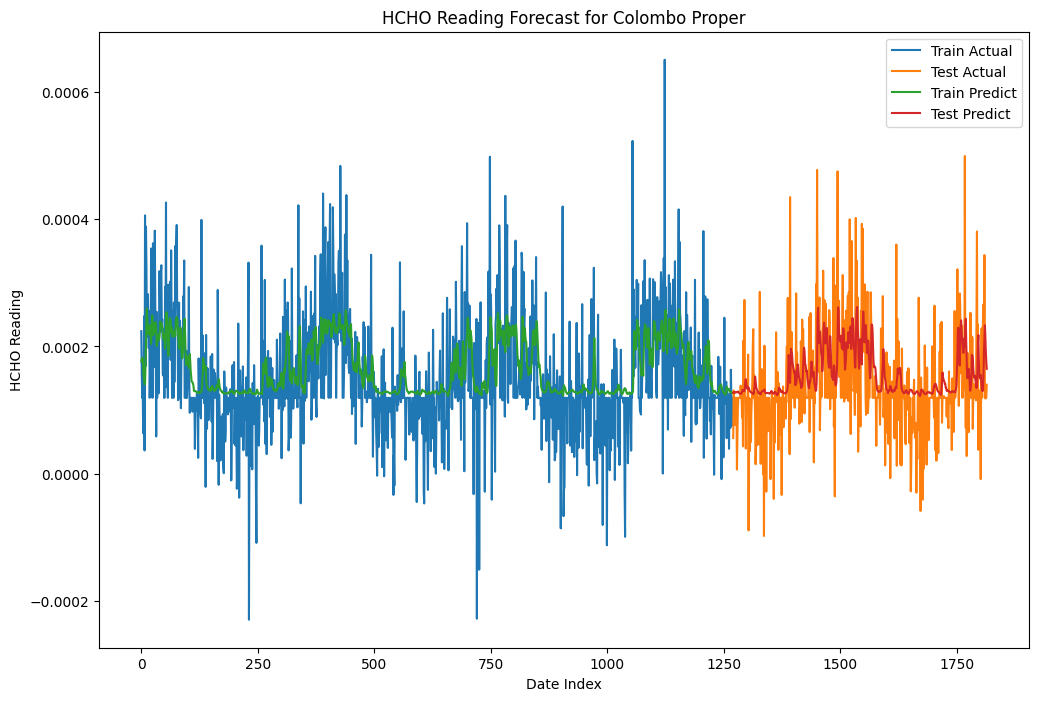

Processing Deniyaya, Matara...
Epoch 1/50
40/40 [==============================] - 21s 22ms/step - loss: 0.0089
Epoch 2/50
40/40 [==============================] - 1s 31ms/step - loss: 0.0047
Epoch 3/50
40/40 [==============================] - 1s 36ms/step - loss: 0.0043
Epoch 4/50
40/40 [==============================] - 1s 36ms/step - loss: 0.0043
Epoch 5/50
40/40 [==============================] - 1s 27ms/step - loss: 0.0044
Epoch 6/50
40/40 [==============================] - 1s 23ms/step - loss: 0.0044
Epoch 7/50
40/40 [==============================] - 1s 25ms/step - loss: 0.0044
Epoch 8/50
40/40 [==============================] - 1s 23ms/step - loss: 0.0045
Epoch 9/50
40/40 [==============================] - 1s 23ms/step - loss: 0.0044
Epoch 10/50
40/40 [==============================] - 1s 23ms/step - loss: 0.0044
Epoch 11/50
40/40 [==============================] - 1s 24ms/step - loss: 0.0044
Epoch 12/50
40/40 [==============================] - 1s 23ms/step - loss: 0.0043
Epoch

In [ ]:
for location in df_pandas['Location'].unique():
    print(f"Processing {location}...")
    loc_data = df_pandas[df_pandas['Location'] == location]
    loc_data['Current Date'] = pd.to_datetime(loc_data['Current Date'])
    loc_data.set_index('Current Date', inplace=True)

    if loc_data['HCHO Reading'].isnull().all():
        print(f"All data for {location} are NaN. Skipping...")
        continue

    # Normalize HCHO Reading
    loc_data['Scaled HCHO'] = scaler.fit_transform(loc_data[['HCHO Reading']])
    X, y = create_dataset(loc_data['Scaled HCHO'].values, time_step=10)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM input

    if len(X) < 10:
        print(f"Not enough data to fit LSTM for {location}")
        continue

    train_size = int(len(X) * 0.70)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]




    model = Sequential([
      LSTM(25, return_sequences=True, input_shape=(10, 1)),
      LSTM(25, return_sequences=True),  # Additional LSTM layer
      LSTM(25, return_sequences=True),  # Additional LSTM layer
      LSTM(25),
      Dense(1)

    ])



    model.compile(optimizer=Adam(0.01), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Store results
    results[location] = (train_predict, test_predict)

    # Compute and store evaluation metrics
    mse = mean_squared_error(y_test_inv, test_predict)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, test_predict)
    mape = np.mean(np.abs((y_test_inv - test_predict) / y_test_inv)) * 100 if np.all(y_test_inv != 0) else None

    evaluation_metrics[location] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    # Visualization for each location
    plt.figure(figsize=(12, 8))
    plt.plot(y_train_inv, label='Train Actual')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, label='Test Actual')
    plt.plot(train_predict, label='Train Predict')
    plt.plot(np.arange(len(train_predict), len(train_predict) + len(test_predict)), test_predict, label='Test Predict')
    plt.title(f'HCHO Reading Forecast for {location}')
    plt.xlabel('Date Index')
    plt.ylabel('HCHO Reading')
    plt.legend()
    plt.show()

In [ ]:
# Optionally convert results and metrics to DataFrame for further analysis
forecast_df = pd.DataFrame.from_dict({k: [v[0], v[1]] for k, v in results.items()}, orient='index')
metrics_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index')
print(metrics_df)

In [ ]:
# Plot forecasted values along with actual values for each location
for location, (train_predict, test_predict) in results.items():
    loc_data = df_pandas[df_pandas['Location'] == location]
    loc_data['Current Date'] = pd.to_datetime(loc_data['Current Date'])
    loc_data.set_index('Current Date', inplace=True)
    y_test_inv = scaler.inverse_transform(loc_data['Scaled HCHO'].iloc[-len(test_predict):].values.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label=f'{location} Actual', linestyle='-')
    plt.plot(test_predict, label=f'{location} Predicted')
    plt.title(f'HCHO Reading Forecast for {location}')
    plt.xlabel('Date Index')
    plt.ylabel('HCHO Reading')
    plt.legend()
    plt.show()


In [ ]:
# Plot evaluation metrics
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Evaluation Metrics by Location')
plt.xlabel('Location')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.show()

#**4. Additional Explantory Data Analysis**

In [ ]:
from pyspark.sql.functions import col

# Assuming df_spark is your original DataFrame
df_spark_additional = df_spark.select([col(col_name).alias(col_name) for col_name in df_spark.columns])

In [ ]:
from pyspark.sql.functions import col

# Define the locations to keep
locations_to_keep = ['Kurunegala Proper', 'Colombo Proper', 'Nuwara Eliya Proper']

# Filter the DataFrame to keep only the rows with the specified locations
filtered_df = df_spark_additional.filter(col('Location').isin(locations_to_keep))

# Get unique locations from the filtered DataFrame
unique_locations = filtered_df.select('Location').distinct().rdd.map(lambda row: row[0]).collect()

# Print the unique locations
for location in unique_locations:
    print(location)

In [ ]:
# Reading the file
additional_data = spark.read.csv("/content/drive/My Drive/Data Engineering/additional_data.csv", header=False, inferSchema = True)

print(additional_data.columns)

# Define the columns you want to drop
columns_to_drop = ['_c0', '_c2', '_c3', '_c4', '_c7', '_c9','_c10', '_c11', '_c12','_c13']

# Drop the specified columns
additional_data = additional_data.drop(*columns_to_drop)

print(additional_data.columns)



# # Rename the columns to more meaningful names
additional_spark = additional_data.withColumnRenamed('_c1', 'Location') \
                   .withColumnRenamed('_c5', 'Current Date') \
                   .withColumnRenamed('_c6', 'Precipitation') \
                   .withColumnRenamed('_c8', 'Temperature Average')


# Convert Spark DataFrame to Pandas DataFrame
additional_pandas = additional_spark.toPandas()

# Print the Pandas DataFrame
print(additional_pandas)

In [ ]:
# Assuming 'Location' is the column containing location information
unique_locations = additional_pandas['Location'].unique()

# List of locations to remove
locations_to_remove = ['CHINA BAY, CE', 'PUTTALAM, CE']

# Filter out unwanted rows
filtered_data = additional_pandas[~additional_pandas['Location'].isin(locations_to_remove)]
additional_pandas = filtered_data.copy()

# Print the modified DataFrame
for location in filtered_data['Location'].unique():
    print(location)



In [ ]:
# Assuming 'Location' is the column containing location information
additional_pandas['Location'] = additional_pandas['Location'].replace({
    'KURUNEGALA, CE': 'Kurunegala Proper',
    'COLOMBO, CE': 'Colombo Proper',
    'NUWARA ELIYA, CE': 'Nuwara Eliya Proper'
})

# Filter out unwanted entries including 'NAME'
filtered_locations = additional_pandas['Location'].unique()
filtered_locations = [location for location in filtered_locations if location != 'NAME']

for location in filtered_locations:
    print(location)



In [ ]:
# Delete the first row of the DataFrame
additional_pandas = additional_pandas.drop(0)

# Print the modified DataFrame
print(additional_pandas)


In [ ]:
from pyspark.sql.functions import col

# Convert 'Current Date' to datetime object specifying the date format
additional_pandas['Current Date'] = pd.to_datetime(additional_pandas['Current Date'], format='%Y/%m/%d')

# Convert the Pandas DataFrame to a Spark DataFrame
additional_spark = spark.createDataFrame(additional_pandas)

# Join the two DataFrames based on 'Location' and 'Current Date'
joined_data = df_spark_additional.join(additional_spark, on=['Location', 'Current Date'], how='inner')

# Print the joined DataFrame
joined_data.show()

In [ ]:
joined_data.head()

In [ ]:
import matplotlib.pyplot as plt

# First, convert the Spark DataFrame to a Pandas DataFrame if necessary
# Assuming 'joined_data' is a Spark DataFrame
pandas_df = joined_data.toPandas()

# Convert 'Current Date' to datetime if it's not already
pandas_df['Current Date'] = pd.to_datetime(pandas_df['Current Date'])

# Getting unique locations
locations = pandas_df['Location'].unique()

# Plotting data for each location
for location in locations:
    # Filter data for the current location
    loc_data = pandas_df[pandas_df['Location'] == location]

    # Sorting data by date to ensure the plot lines are continuous and correct
    loc_data = loc_data.sort_values('Current Date')

    # Creating the plot
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plotting 'HCHO Reading' on the primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('HCHO Reading', color=color)
    ax1.plot(loc_data['Current Date'], loc_data['HCHO Reading'], color=color, label='HCHO Reading')
    ax1.tick_params(axis='y', labelcolor=color)

    # Creating a second y-axis for 'Temperature'
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Temperature Average', color=color)
    ax2.plot(loc_data['Current Date'], loc_data['Temperature Average'], color=color, label='Temperature Average')
    ax2.tick_params(axis='y', labelcolor=color)

    # Adding a title
    plt.title(f'Temperature and HCHO Reading over Time for {location}')

    # Displaying the legend
    # This ensures that the legend contains labels from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    # Layout adjustment
    plt.tight_layout()

    # Show plot
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'joined_data' is a Spark DataFrame and converting it to Pandas
pandas_df = joined_data.toPandas()

# Converting 'Current Date' to datetime and handling NaNs for 'Precipitation'
pandas_df['Current Date'] = pd.to_datetime(pandas_df['Current Date'])
pandas_df['Precipitation'] = pandas_df['Precipitation'].fillna(0.0).astype(float)

# Printing data types to debug
print(pandas_df.dtypes)

# Plotting for each location
locations = pandas_df['Location'].unique()
for location in locations:
    loc_data = pandas_df[pandas_df['Location'] == location]
    loc_data = loc_data.sort_values('Current Date')

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Date')
    ax1.set_ylabel('HCHO Reading', color='tab:red')
    ax1.plot(loc_data['Current Date'], loc_data['HCHO Reading'], color='tab:red', label='HCHO Reading')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Precipitation', color='tab:blue')
    ax2.plot(loc_data['Current Date'], loc_data['Precipitation'], color='tab:blue', label='Precipitation', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax2.legend(loc='upper right')
    plt.title(f'Precipitation and HCHO Reading over Time for {location}')
    plt.tight_layout()
    plt.show()


In [ ]:
# # Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
# plot_data = joined_data.select("DayOfYear", "Temperature Average", "HCHO Reading", "Location").toPandas()


In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# scatter = plt.scatter(plot_data['DayOfYear'], plot_data['HCHO Reading'], c=plot_data['Temperature Average'], cmap='coolwarm', alpha=0.5)
# plt.colorbar(scatter, label='Temperature Average (°C)')
# plt.xlabel('Day of Year')
# plt.ylabel('HCHO Reading')
# plt.title('HCHO Readings Across the Year by Temperature')
# plt.show()

In [ ]:
# import seaborn as sns

# # Create a FacetGrid to show different plots for each location
# g = sns.FacetGrid(plot_data, col="Location", col_wrap=4, height=4)
# g.map(plt.scatter, "DayOfYear", "HCHO Reading", alpha=0.5)
# g.add_legend()
# g.set_axis_labels("Day of Year", "HCHO Reading")
# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('HCHO Readings Across the Year by Location')
# plt.show()

In [ ]:
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.feature import VectorAssembler

# # Initialize a list to store models and their summaries
# model_summaries = []

# # Loop through each unique location
# unique_locations = indexed_data.select("LocationIndexed").distinct().collect()
# for location in unique_locations:
#     # Filter data for the current location
#     location_data = indexed_data.filter(col("LocationIndexed") == location["LocationIndexed"])

#     # Prepare features for regression
#     assembler = VectorAssembler(
#         inputCols=["DayOfYear", "Temperature Average"],
#         outputCol="features"
#     )
#     location_features = assembler.transform(location_data)

#     # Define and fit the linear regression model
#     lr = LinearRegression(featuresCol='features', labelCol='HCHO Reading')
#     lr_model = lr.fit(location_features)

#     # Collect the model summary
#     model_summaries.append({
#         "location": location["LocationIndexed"],
#         "coefficients": lr_model.coefficients,
#         "intercept": lr_model.intercept,
#         "r2": lr_model.summary.r2
#     })

# # Output model summaries
# for summary in model_summaries:
#     print(f"Location: {summary['location']}")
#     print(f"  Coefficients: {summary['coefficients']}")
#     print(f"  Intercept: {summary['intercept']}")
#     print(f"  R-squared: {summary['r2']}")
#     print("\n")


In [ ]:
# from pyspark.sql.functions import col, dayofyear
# from pyspark.sql.types import FloatType

# # Convert 'Temperature Average' to float
# joined_data = joined_data.withColumn("Temperature Average", col("Temperature Average").cast(FloatType()))

# # Convert 'Current Date' to 'DayOfYear'
# joined_data = joined_data.withColumn("DayOfYear", dayofyear(col("Current Date")))


# from pyspark.ml.feature import StringIndexer, VectorAssembler
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml import Pipeline

# # Index 'Location' to convert it to a numeric form
# indexer = StringIndexer(inputCol="Location", outputCol="LocationIndexed")
# indexed_data = indexer.fit(joined_data).transform(joined_data)

# from pyspark.ml.feature import StringIndexer, VectorAssembler
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml import Pipeline

# # Index 'Location' to convert it to a numeric form
# indexer = StringIndexer(inputCol="Location", outputCol="LocationIndexed")
# indexed_data = indexer.fit(joined_data).transform(joined_data)

# # Prepare features for regression
# assembler = VectorAssembler(
#     inputCols=["DayOfYear", "LocationIndexed", "Temperature Average"],
#     outputCol="features"
# )

# # Prepare the final dataset
# final_data = assembler.transform(indexed_data)


# # Define and fit the linear regression model
# lr = LinearRegression(featuresCol='features', labelCol='HCHO Reading')
# lr_model = lr.fit(final_data)

# # Output the coefficients and intercept
# print("Coefficients:", lr_model.coefficients)
# print("Intercept:", lr_model.intercept)

In [ ]:
# # Convert the necessary columns to Pandas for visualization
# plot_data = final_data.select("DayOfYear", "LocationIndexed", "Temperature Average", "HCHO Reading").toPandas()

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Create a new figure for 3D plotting
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Scatter plot using 'DayOfYear', 'Temperature Average', and 'HCHO Reading'
# scatter = ax.scatter(
#     plot_data['DayOfYear'],
#     plot_data['Temperature Average'],
#     plot_data['HCHO Reading'],
#     c=plot_data['Temperature Average'],  # Color by temperature
#     cmap='coolwarm',
#     marker='o'
# )

# # Color bar indicating temperature values
# cbar = fig.colorbar(scatter, ax=ax)
# cbar.set_label('Temperature Average (°C)')

# # Set labels and title
# ax.set_xlabel('Day of Year')
# ax.set_ylabel('Temperature Average (°C)')
# ax.set_zlabel('HCHO Reading')
# ax.set_title('3D Scatter Plot of HCHO Readings')

# # Show the plot
# plt.show()


In [ ]:
# # Ensure the data types are correct for correlation calculation
# from pyspark.sql.functions import col
# additional_spark = additional_spark.withColumn("Temperature Average", col("Temperature Average").cast("float"))
# additional_spark = additional_spark.withColumn("Precipitation", col("Precipitation").cast("float"))

# # Join the two DataFrames based on 'Location' and 'Current Date'
# joined_data = df_spark_additional.join(additional_spark, ["Location", "Current Date"], "inner")

# # Show the joined DataFrame to verify
# joined_data.show()

# # Calculate correlation between HCHO Reading and Temperature Average, handling possible errors with try-except
# try:
#     temperature_correlation = joined_data.stat.corr('HCHO Reading', 'Temperature Average')
#     print("Correlation between HCHO Reading and Temperature Average:", temperature_correlation)
# except Exception as e:
#     print("Error calculating temperature correlation:", str(e))

# # Calculate correlation between HCHO Reading and Precipitation, handling possible errors
# try:
#     precipitation_correlation = joined_data.stat.corr('HCHO Reading', 'Precipitation')
#     print("Correlation between HCHO Reading and Precipitation:", precipitation_correlation)
# except Exception as e:
#     print("Error calculating precipitation correlation:", str(e))


In [ ]:
# joined_data.head()

In [ ]:
# # Calculate correlation between HCHO Reading and Temperature
# temperature_correlation = joined_data.stat.corr('HCHO Reading', 'Temperature Average')

# # Calculate correlation between HCHO Reading and Precipitation
# precipitation_correlation = additional_spark.stat.corr('HCHO Reading', 'Precipitation')

# # Print the correlations
# print("Correlation between HCHO Reading and Temperature:", temperature_correlation)
# print("Correlation between HCHO Reading and Precipitation:", precipitation_correlation)


In [ ]:
# from pyspark.sql.functions import mean

# # Calculate mean HCHO Reading per location
# location_mean_hcho = joined_data.groupBy('Location').agg(mean('HCHO Reading').alias('Mean HCHO Reading'))

# # Show the results
# location_mean_hcho.show()


In [ ]:
# from pyspark.sql.functions import mean

# # Calculate mean HCHO Reading per location
# location_mean_hcho = joined_data.groupBy('Location').agg(mean('HCHO Reading').alias('Mean HCHO Reading'))

# # Show the results
# location_mean_hcho.show()


In [ ]:
# from pyspark.ml.feature import StringIndexer, VectorAssembler
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml import Pipeline

# # Create a StringIndexer to convert the 'Location' column into a numeric 'LocationIndexed' column
# indexer = StringIndexer(inputCol="Location", outputCol="LocationIndexed")

# # Optionally, if you need to use OneHotEncoding, uncomment the following lines
# # from pyspark.ml.feature import OneHotEncoder
# # encoder = OneHotEncoder(inputCols=["LocationIndexed"], outputCols=["LocationEncoded"])

# # Assemble features, including 'DayOfYear' and 'LocationIndexed'
# assembler = VectorAssembler(inputCols=["DayOfYear", "LocationIndexed"], outputCol="features")

# # Define the linear regression model
# lr = LinearRegression(featuresCol='features', labelCol='HCHO Reading')

# # Set up a pipeline that includes the indexer, assembler, and the linear regression model
# pipeline = Pipeline(stages=[indexer, assembler, lr])

# # Fit the pipeline to the data
# model = pipeline.fit(joined_data)

# # Extract the fitted model from the pipeline to access coefficients
# lr_model = model.stages[-1]

# print("Coefficients:", lr_model.coefficients)
# print("Intercept:", lr_model.intercept)


In [ ]:
# import matplotlib.pyplot as plt

# # Retrieve the indexer from the pipeline
# indexer_model = model.stages[0]
# # Get the labels corresponding to each index
# location_labels = indexer_model.labels

# # Extract coefficients for locations only
# # Assuming the first coefficient is 'DayOfYear', we skip it
# location_coefficients = lr_model.coefficients[1:]

# # Create a bar plot for the locations
# plt.figure(figsize=(10, 4))
# plt.bar(location_labels, location_coefficients, color='skyblue')
# plt.xlabel('Location')
# plt.ylabel('Impact on HCHO Reading (Coefficient Value)')
# plt.title('Impact of Locations on HCHO Reading')
# plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
# plt.tight_layout()  # Adjust layout to not cut off labels

# # Show the plot
# plt.show()


In [ ]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col, dayofyear, mean
# from pyspark.ml.feature import StringIndexer, VectorAssembler
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml import Pipeline
# import matplotlib.pyplot as plt

# # Start Spark session
# spark = SparkSession.builder.appName("sparkApp").getOrCreate()

# # Read and prepare additional data
# additional_data = spark.read.csv("/content/drive/My Drive/Data Engineering/additional_data.csv", header=False, inferSchema=True)
# columns_to_drop = ['_c0', '_c2', '_c3', '_c4', '_c7', '_c9', '_c10', '_c11', '_c12', '_c13']
# additional_data = additional_data.drop(*columns_to_drop)
# additional_data = additional_data.withColumnRenamed('_c1', 'Location') \
#                                  .withColumnRenamed('_c5', 'Current Date') \
#                                  .withColumnRenamed('_c6', 'Precipitation') \
#                                  .withColumnRenamed('_c8', 'Temperature Average') \
#                                  .withColumn("Temperature Average", col("Temperature Average").cast("float")) \
#                                  .withColumn("Precipitation", col("Precipitation").cast("float"))

# # Assume df_spark is your original DataFrame already loaded
# # Filter based on specific locations
# locations_to_keep = ['Kurunegala Proper', 'Colombo Proper', 'Nuwara Eliya Proper']
# df_spark_filtered = df_spark.filter(col('Location').isin(locations_to_keep))

# # Ensure 'Current Date' is a date type and convert it to 'DayOfYear'
# df_spark_filtered = df_spark_filtered.withColumn("DayOfYear", dayofyear(col("Current Date")))

# # Join DataFrames
# joined_data = df_spark_filtered.join(additional_data, ["Location", "Current Date"], "inner")

# # Set up and fit the pipeline with Linear Regression
# indexer = StringIndexer(inputCol="Location", outputCol="LocationIndexed")
# assembler = VectorAssembler(inputCols=["DayOfYear", "LocationIndexed"], outputCol="features")
# lr = LinearRegression(featuresCol='features', labelCol='HCHO Reading')
# pipeline = Pipeline(stages=[indexer, assembler, lr])
# model = pipeline.fit(joined_data)

# # Extract and plot coefficients
# indexer_model = model.stages[0]
# location_labels = indexer_model.labels
# lr_model = model.stages[-1]
# location_coefficients = lr_model.coefficients[1:]  # Exclude DayOfYear coefficient
# plt.figure(figsize=(10, 4))
# plt.bar(location_labels, location_coefficients, color='skyblue')
# plt.xlabel('Location')
# plt.ylabel('Impact on HCHO Reading (Coefficient Value)')
# plt.title('Impact of Locations on HCHO Reading')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()
